# Data Science Case Study - Train Travel Company

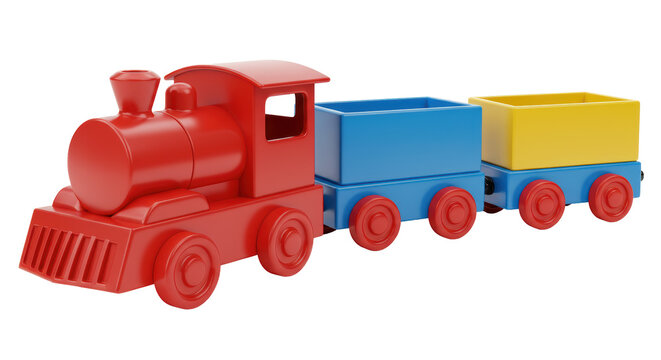

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import yaml

from shapely.geometry import Point
import geopandas as gpd
from geopy.geocoders import Nominatim
from shapely.validation import make_valid

import holidays
import time

from rapidfuzz import process, fuzz
from typing import Optional
import pandas as pd
from tqdm import tqdm
import os

from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score, cross_validate
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor

from prophet import Prophet

plt.style.use('ggplot')
pd.options.display.max_columns = 500
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None)

/Users/liddingtonb/Library/Caches/pypoetry/virtualenvs/case-study-E4SsEFgE-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## Read Data

In [2]:
data_path = Path.cwd().resolve().parents[1] / "data"
sales = pd.read_csv(data_path / "sales.csv", index_col=0)
stations = pd.read_csv(data_path / "stations.csv", index_col=0)

___Sales Data Dictionary___

    - date: yyyy-mm-dd format. increments of one day. not unique.
    - sales: number of sales on that given day, relative to the station
    - station: name of a station in the UK

___Stations Data Dictionary___

    - station: name of the station in the UK
    - lat: latitude coordinate
    - lon: longitude coordinate
    - operator: responible entity for the ticket / journey

## Operator Observation

    Trainline is a different kind of entity to English / Welsh / Scottish Rail. 
    The latter is a private or public body that own the trains and journeys
    the other is a vendor which sells tickets on behalf of these bodies.

***Why this matters***

    Railways may sell tickets through many channels and Trainline is simply just one of them (i.e. tickets at station, their own website etc). A sale to trainline is also a sale to whichever railway operates at the station.

    We will need to map stations to the correct body based on the lat/lon data so that sales totals for each railway is fully represenative. 
    (e.g. when lat/lon falls inside the Wales then attribute sales to Welsh Railway.)

***Risks***

    Trainline take a portion of the ticket sales as revenue and the rest is passed onto the body that owns the station. Care will need to be taken to ensure reasonable estimates.


***From now on***

***Railways - refers to the english/welsh/scottish railway companies***

***Trainline - will be refered to by its namesake***


## Engineering Features & Cleaning

### Mapping stations to nations

Downloaded GeoJSON object from Gov Website for mapping
https://geoportal.statistics.gov.uk/datasets/e4cab2a2419f46d7847dafb50a159aa7_0/explore

In [3]:
# From my understanding given the resolution of the gov file, error could be up to 1000m. 
# This is forgivable given that nations are large. 
# If error is over 1000m then it is likely mapped poorly

sales['station'] = sales['station'].str.replace("'", "", regex=False).str.strip()

# Convert to GeoDataFrame
gdf_stations = gpd.GeoDataFrame(
    stations,
    geometry=gpd.points_from_xy(stations["lon"], stations["lat"]),
    crs="EPSG:4326"
)
countries = gpd.read_file(data_path / "countries.geojson").to_crs(gdf_stations.crs)

# Buffer stations by x meters then check point-in-polygon
gdf_stations_m = gdf_stations.to_crs(27700)
countries_m = countries.to_crs(27700)
x = 1000
gdf_stations_buf = gdf_stations_m.copy()
gdf_stations_buf["geometry"] = gdf_stations_buf.buffer(x)

joined = gpd.sjoin(
    gdf_stations_buf,
    countries_m[["CTRY22NM", "geometry"]],
    how="left",
    predicate="intersects"
)
gdf_stations_w_nation = (
    joined.rename(columns={"CTRY22NM": "nation"})
          .drop(columns=["geometry", "index_right"], errors="ignore")
)

# Checking errors clear
gdf_stations_w_nation.query("nation.isna()")

,station,lat,lon,operator,nation


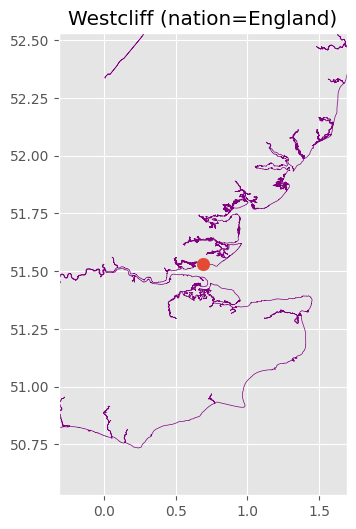

Westcliff → England: 572.7 m


572.7037673039879

In [4]:
# None should have errors above 1000m
station = "Westcliff"
nation = "England"

def _pick_station_row(df: gpd.GeoDataFrame, station: str, prefer_non_null_nation=True):
    sub = df.loc[df["station"] == station]
    if sub.empty:
        raise ValueError(f"Station '{station}' not found.")
    if prefer_non_null_nation and "nation" in sub.columns and sub["nation"].notna().any():
        sub = sub[sub["nation"].notna()]
    return sub.iloc[0]

def zoom_station(df: gpd.GeoDataFrame, station: str, pad_deg: float = 1.0):
    row = _pick_station_row(df, station)
    pt = gpd.GeoSeries([Point(row.lon, row.lat)], crs="EPSG:4326")

    ax = countries.plot(figsize=(6, 6), edgecolor="purple", facecolor="none")
    pt.plot(ax=ax, markersize=80)
    plt.xlim(row.lon - pad_deg, row.lon + pad_deg)
    plt.ylim(row.lat - pad_deg, row.lat + pad_deg)
    title_nation = row["nation"] if "nation" in row else None
    plt.title(f"{station} (nation={title_nation})")
    plt.show()

def location_offset_error(station: str, nation: str) -> float:
    row = _pick_station_row(gdf_stations, station, prefer_non_null_nation=False)
    pt = gpd.GeoSeries([Point(row.lon, row.lat)], crs="EPSG:4326").to_crs(27700).iloc[0]
    sel = countries.loc[countries["CTRY22NM"] == nation]
    if sel.empty:
        raise ValueError(f"Nation '{nation}' not found in countries['CTRY22NM'].")
    poly = sel.to_crs(27700).geometry.union_all()
    dist_m = pt.distance(poly)
    print(f"{station} → {nation}: {dist_m:.1f} m")
    return float(dist_m)

zoom_station(df=gdf_stations_w_nation,station=station)
location_offset_error(station=station, nation=nation)


In [5]:
# Now given the nation data we can map stations to railways
gdf_stations_w_nation["railway"] = gdf_stations_w_nation.apply(
    lambda row: (
        "English Rail" if row["operator"] == "Trainline" and row["nation"] == "England" else
        "Scottish Rail" if row["operator"] == "Trainline" and row["nation"] == "Scotland" else
        "Welsh Rail" if row["operator"] == "Trainline" and row["nation"] == "Wales" else
        row["operator"]
    ),
    axis=1
)
# Add a flag for trainline figures
gdf_stations_w_nation["trainline_assisted_sales"] = (gdf_stations_w_nation["operator"] == "Trainline").astype(bool)
gdf_stations_w_nation.rename(columns={"operator": "source_operator"}, inplace=True)


In [6]:
# Check one-to-one realationship between stations and operators before engineering steps
gdf_stations_w_nation.groupby('station')['source_operator'].nunique().sort_values(ascending=False)

station
Exeter Central        2
Abbey Wood            1
Oakham                1
Orpington             1
Ormskirk              1
                     ..
Forres                1
Ford Newton           1
Folkestone West       1
Folkestone Central    1
York                  1
Name: source_operator, Length: 1259, dtype: int64

In [7]:
gdf_stations_w_nation.query("station == 'Exeter Central'")

,station,lat,lon,source_operator,nation,railway,trainline_assisted_sales
388,Exeter Central,51.46,-0.90,Trainline,England,English Rail,True
389,Exeter Central,50.72,-3.53,English Rail,England,English Rail,False


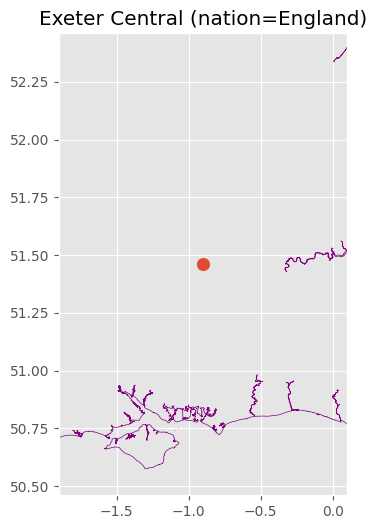

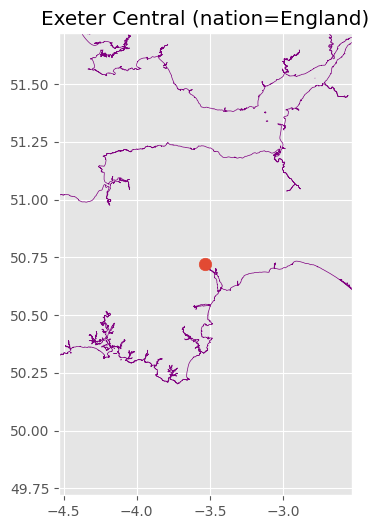

(None, None)

In [8]:
# Bottom one is correct
zoom_station(
    df=gdf_stations_w_nation.query("station == 'Exeter Central' & source_operator == 'Trainline'"),
    station='Exeter Central'
), zoom_station(
    df=gdf_stations_w_nation.query("station == 'Exeter Central' & source_operator == 'English Rail'"),
    station='Exeter Central'
)

In [9]:
# Because of the incorrect lat/lon we are dropping the row. 
# Hard to say whether Exeter Central should update to be Trainline or whether the Trainline entry is wrong
# As the row was wrong we shall leave Exeter as False for Trainline Assisted Sales for now
gdf_stations_w_nation = gdf_stations_w_nation[~((gdf_stations_w_nation.station == "Exeter Central") & (gdf_stations_w_nation.source_operator == "Trainline"))]

### Join datasets

***State***

    It looks like the stations don't match 1-1 between the datasets.
    Stations listed in the stations dataset can either match with the stations in sales or not at all.
    For example '%manchester%' has 3 entries in Sales but in Stations it has 8 entries.

***Evaluation***

    Some match 1-1 and some will likely match once processed and fuzzy matched with high confidence.
    We can then match by distance being close (i.e. within somesort of range).
    Doing this where we can can allow us to match trainline_assisted_sales.

    However, if for some examples this doesn't work thats okay.
    Due to the logic with operator = 'trainline' which we did above we can infer the acutal railway by region location, station dataset doesn't have sales data, coords can be retrieved reliably from online sources/libraries there isn't much value from trying to match data further or whitespacing by populating train stations which have no sales data.

***Actions***

    - Normanlise names
    - Match using high confidence fuzzy
    - Match using neaby distance.

In [10]:
# Calculating distance between two coords
def nearest_in_sales(lat, lon, sales_stn):

    R = 6371000.0  # Earth radius in meters

    # Convert to radians
    qlat = np.radians(lat)
    qlon = np.radians(lon)
    sales_lat_rad = np.radians(sales_stn['lat'].values)
    sales_lon_rad = np.radians(sales_stn['lon'].values)

    # Haversine distance
    dlat = sales_lat_rad - qlat
    dlon = sales_lon_rad - qlon
    a = np.sin(dlat / 2.0)**2 + np.cos(qlat) * np.cos(sales_lat_rad) * np.sin(dlon / 2.0)**2
    c = 2.0 * np.arctan2(np.sqrt(a), np.sqrt(1.0 - a))
    d = R * c  # distances in meters

    # Index of nearest station
    idx = int(np.argmin(d))

    return (
        sales_stn.iloc[idx]['station'],
        float(d[idx]),
        float(sales_stn.iloc[idx]['lat']),
        float(sales_stn.iloc[idx]['lon'])
    )


In [11]:
geolocator = Nominatim(user_agent="station_locator")

def get_coords(name):
    try:
        loc = geolocator.geocode(f"{name} railway station, UK")
        if loc:
            return loc.latitude, loc.longitude
    except Exception:
        pass
    return None, None

unique_stations = sales['station'].drop_duplicates().to_list()

coords = {}
for name in unique_stations:
    lat, lon = get_coords(name)
    coords[name] = (lat, lon)
    time.sleep(1)

sales['lat'] = sales['station'].map(lambda s: coords.get(s, (None, None))[0])
sales['lon'] = sales['station'].map(lambda s: coords.get(s, (None, None))[1])

sales.to_csv(data_path / "sales_with_coords.csv")
# sales = pd.read_csv(data_path / "sales_with_coords.csv", index_col=0)

In [12]:
# Some older code used in repo pinch I helped write
def match_names(original_df: pd.DataFrame,
                name_column: str,
                matching_df: pd.DataFrame,
                matching_names: str,
                alt_names: Optional[str] = None,
                min_match_score: int = 90):
    matches = []
    output_df = original_df

    fuzzy_names_to_match = original_df[name_column].tolist()
    svc_names_list = matching_df[matching_names].tolist()

    # Default to empty dict if no alternate names provided
    if alt_names is None:
        alternate_name_dict = {}
    else:
        alternate_name_dict = dict(zip(original_df[name_column], original_df[alt_names]))

    for name in tqdm(fuzzy_names_to_match, desc="Matching Names", unit="name"):
        best_matches = process.extract(name, svc_names_list, scorer=fuzz.ratio)

        # If a match is found for the first name, add it to the matches list
        if any(match[1] >= min_match_score for match in best_matches):
            for match in best_matches:
                if match[1] >= min_match_score:
                    matches.append((match[0], name, match[1]))
        else:
            # Try matching with the alternate name if no match is found
            alternate_name = alternate_name_dict.get(name, None)
            if alternate_name:
                alternate_matches = process.extract(alternate_name, svc_names_list, scorer=fuzz.ratio)
                # If a match is found with the alternate name, add it to the matches list
                if any(match[1] >= min_match_score for match in alternate_matches):
                    for match in alternate_matches:
                        if match[1] >= min_match_score:
                            matches.append((match[0], name, match[1]))

    # Create DataFrame of matched results
    matched_df = output_df[output_df[name_column].isin([m[1] for m in matches])].copy()

    matched_by_dict = {m[1]: m[0] for m in matches}
    match_score_dict = {m[1]: m[2] for m in matches}

    matched_df['matched_by'] = matched_df[name_column].map(matched_by_dict)
    matched_df['match_score'] = matched_df[name_column].map(match_score_dict)

    return matched_df

_station_sales = match_names(sales, 'station', gdf_stations_w_nation, 'station', min_match_score=95)

Matching Names: 100%|██████████| 70100/70100 [00:05<00:00, 12837.76name/s]


In [13]:
# All matching was 100% scores, hence we can just do a left join now
_station_sales.describe()

,sales,match_score
count,70100.000000,70100.000000
mean,337.535624,99.969697
std,390.673461,0.301513
min,92.314156,96.969697
25%,135.779942,100.000000
50%,200.444485,100.000000
75%,371.568482,100.000000
max,2754.247272,100.000000


In [14]:
gdf_stations_w_nation.query("trainline_assisted_sales").to_csv(data_path / "trainline_stations.csv")

I notice now we have a 100% match for the sales dataset, none of the trainline defined datapoints made it through to a matching sales station.

Exporting and observing in Kepler shows that Trainline are engaging in advanced marketing tactics.

This, however, does bring into question the accuracy of the rest of the dataset as a whole. However, as I construct both the nation ind and coords from external sources data the dataset should retain integrity
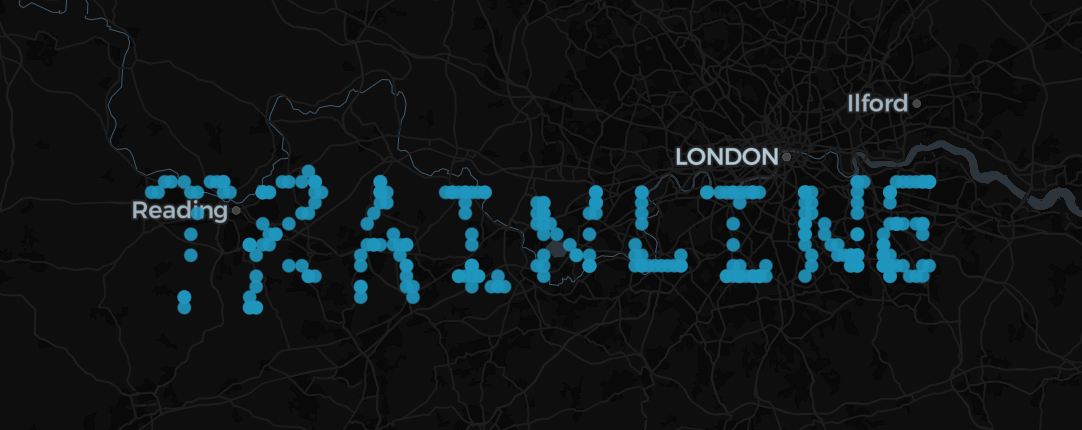

In [15]:
# As all were matches with this step the matching by distance is no longer needed
station_sales = pd.merge(
    sales,
    gdf_stations_w_nation[[
        "station", "source_operator", "nation", "railway",
        "trainline_assisted_sales", "lat", "lon"
    ]],
    on="station",
    how="left",
    suffixes=("", "_right")
)
for col in ["lat", "lon"]:
    station_sales[col] = station_sales[col].fillna(station_sales[f"{col}_right"])

station_sales = station_sales.drop(columns=["lat_right", "lon_right"])


/var/folders/nd/bjvm3cd953z10kb2c4z1rs4rnnf7fh/T/ipykernel_98754/1560360316.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  station_sales[col] = station_sales[col].fillna(station_sales[f"{col}_right"])


In [16]:
station_sales[station_sales['station'].str.contains('manchester', case=False, na=False)].head()

,date,sales,station,lat,lon,source_operator,nation,railway,trainline_assisted_sales
0,2023-01-01,1346.840438,Manchester Piccadilly,53.47,-2.23,English Rail,England,English Rail,False
1,2023-01-02,1347.696314,Manchester Piccadilly,53.47,-2.23,English Rail,England,English Rail,False
2,2023-01-03,1349.757360,Manchester Piccadilly,53.47,-2.23,English Rail,England,English Rail,False
3,2023-01-04,1354.646786,Manchester Piccadilly,53.47,-2.23,English Rail,England,English Rail,False
4,2023-01-05,1348.356770,Manchester Piccadilly,53.47,-2.23,English Rail,England,English Rail,False


In [17]:
dupes = station_sales.duplicated(subset=["station", "date"])
print("Duplicate station-date rows:", dupes.sum())

Duplicate station-date rows: 0


### Adding Date time Features

In [18]:
station_sales["date"] = pd.to_datetime(station_sales["date"], format="%Y-%m-%d")

station_sales["year"] = station_sales["date"].dt.year
station_sales["month"] = station_sales["date"].dt.month
station_sales["day"] = station_sales["date"].dt.day
station_sales["day_of_week"] = station_sales["date"].dt.day_name()
station_sales["quarter"] = station_sales["date"].dt.quarter
station_sales["is_weekend"] = station_sales["date"].dt.dayofweek >= 5

uk_holidays = holidays.UnitedKingdom(years=station_sales['date'].dt.year.unique())
station_sales['is_holiday'] = station_sales['date'].isin(uk_holidays)
station_sales['holiday_name'] = station_sales['date'].map(uk_holidays)

/var/folders/nd/bjvm3cd953z10kb2c4z1rs4rnnf7fh/T/ipykernel_98754/105215278.py:11: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  station_sales['is_holiday'] = station_sales['date'].isin(uk_holidays)


### Number of Sales Adjustments

***How do we interpret 'sales'?***

    It could be number of ticket sales or the gross revenue. It is hard to say since the value is a decimal.

    Spot checking I think it makes more sense to count these as ticket sales

***Why?***

    11/02/202 | 92.31415573	| Stratford (London) 
    is an example of a row.

    Stratford is a busy station so the station only making £92.31 is unlikely (thats like a few tickets)
    Whereas it being the number of tickets is a little more believeable, although trains can have thousands of footfall in one day. I assume for this case study data is at least somewhat synthetic at minimum.

***Actions***

    You can't have a decimal number of tickets in one day. We will round to the nearest whole number


In [19]:
# Rounding
station_sales['sales'] = station_sales['sales'].round().astype(int)

#### Adding lags and rolling features for sales by groups

In [20]:
def add_rolling_features(
    df: pd.DataFrame,
    feature: str = "sales",
    group_col: str = "station",
    date_col: str = "date",
    windows: list | None = None,
) -> pd.DataFrame:
    if windows is None:
        windows = [1, 3, 7, 14, 28]

    out = df.copy()
    out.sort_values([group_col, date_col], inplace=True)

    for w in windows:
        for stat in ["mean", "std", "sum"]:
            col = f"{group_col}_by_{feature}_{stat}_{w}d"
            out[col] = (
                out.groupby(group_col)[feature]
                .transform(lambda s: s.shift(1).rolling(w, min_periods=1).agg(stat))
            )

    return out

def add_lag_features(
    df: pd.DataFrame,
    feature: str = "sales",
    group_col: str = "station",
    date_col: str = "date",
    windows: list | None = None,
) -> pd.DataFrame:
    if windows is None:
        windows = [1, 3, 7, 14, 28]

    out = df.copy()
    out.sort_values([group_col, date_col], inplace=True)

    for w in windows:
        out[f"{group_col}_by_{feature}_lag_{w}d"] = (
            out.groupby(group_col)[feature].shift(w)
        )

    return out



In [21]:
station_sales = (
    station_sales
      .pipe(add_rolling_features, group_col="station", feature="sales")
      .pipe(add_rolling_features, group_col="railway", feature="sales")
      .pipe(add_rolling_features, group_col="nation",  feature="sales")
      .pipe(add_lag_features, group_col="station", feature="sales")
      .pipe(add_lag_features, group_col="railway", feature="sales")
      .pipe(add_lag_features, group_col="nation",  feature="sales")
)

In [22]:
station_sales.head(1)

,date,sales,station,lat,lon,source_operator,nation,railway,trainline_assisted_sales,year,month,day,day_of_week,quarter,is_weekend,is_holiday,holiday_name,station_by_sales_mean_1d,station_by_sales_std_1d,station_by_sales_sum_1d,station_by_sales_mean_3d,station_by_sales_std_3d,station_by_sales_sum_3d,station_by_sales_mean_7d,station_by_sales_std_7d,station_by_sales_sum_7d,station_by_sales_mean_14d,station_by_sales_std_14d,station_by_sales_sum_14d,station_by_sales_mean_28d,station_by_sales_std_28d,station_by_sales_sum_28d,railway_by_sales_mean_1d,railway_by_sales_std_1d,railway_by_sales_sum_1d,railway_by_sales_mean_3d,railway_by_sales_std_3d,railway_by_sales_sum_3d,railway_by_sales_mean_7d,railway_by_sales_std_7d,railway_by_sales_sum_7d,railway_by_sales_mean_14d,railway_by_sales_std_14d,railway_by_sales_sum_14d,railway_by_sales_mean_28d,railway_by_sales_std_28d,railway_by_sales_sum_28d,nation_by_sales_mean_1d,nation_by_sales_std_1d,nation_by_sales_sum_1d,nation_by_sales_mean_3d,nation_by_sales_std_3d,nation_by_sales_sum_3d,nation_by_sales_mean_7d,nation_by_sales_std_7d,nation_by_sales_sum_7d,nation_by_sales_mean_14d,nation_by_sales_std_14d,nation_by_sales_sum_14d,nation_by_sales_mean_28d,nation_by_sales_std_28d,nation_by_sales_sum_28d,station_by_sales_lag_1d,station_by_sales_lag_3d,station_by_sales_lag_7d,station_by_sales_lag_14d,station_by_sales_lag_28d,railway_by_sales_lag_1d,railway_by_sales_lag_3d,railway_by_sales_lag_7d,railway_by_sales_lag_14d,railway_by_sales_lag_28d,nation_by_sales_lag_1d,nation_by_sales_lag_3d,nation_by_sales_lag_7d,nation_by_sales_lag_14d,nation_by_sales_lag_28d
49070,2023-01-01,111,Ashford International,51.14,0.87,English Rail,England,English Rail,False,2023,1,1,Sunday,1,True,True,New Year's Day,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
station_sales.query("station == 'Aberdeen'").head(10)

,date,sales,station,lat,lon,source_operator,nation,railway,trainline_assisted_sales,year,month,day,day_of_week,quarter,is_weekend,is_holiday,holiday_name,station_by_sales_mean_1d,station_by_sales_std_1d,station_by_sales_sum_1d,station_by_sales_mean_3d,station_by_sales_std_3d,station_by_sales_sum_3d,station_by_sales_mean_7d,station_by_sales_std_7d,station_by_sales_sum_7d,station_by_sales_mean_14d,station_by_sales_std_14d,station_by_sales_sum_14d,station_by_sales_mean_28d,station_by_sales_std_28d,station_by_sales_sum_28d,railway_by_sales_mean_1d,railway_by_sales_std_1d,railway_by_sales_sum_1d,railway_by_sales_mean_3d,railway_by_sales_std_3d,railway_by_sales_sum_3d,railway_by_sales_mean_7d,railway_by_sales_std_7d,railway_by_sales_sum_7d,railway_by_sales_mean_14d,railway_by_sales_std_14d,railway_by_sales_sum_14d,railway_by_sales_mean_28d,railway_by_sales_std_28d,railway_by_sales_sum_28d,nation_by_sales_mean_1d,nation_by_sales_std_1d,nation_by_sales_sum_1d,nation_by_sales_mean_3d,nation_by_sales_std_3d,nation_by_sales_sum_3d,nation_by_sales_mean_7d,nation_by_sales_std_7d,nation_by_sales_sum_7d,nation_by_sales_mean_14d,nation_by_sales_std_14d,nation_by_sales_sum_14d,nation_by_sales_mean_28d,nation_by_sales_std_28d,nation_by_sales_sum_28d,station_by_sales_lag_1d,station_by_sales_lag_3d,station_by_sales_lag_7d,station_by_sales_lag_14d,station_by_sales_lag_28d,railway_by_sales_lag_1d,railway_by_sales_lag_3d,railway_by_sales_lag_7d,railway_by_sales_lag_14d,railway_by_sales_lag_28d,nation_by_sales_lag_1d,nation_by_sales_lag_3d,nation_by_sales_lag_7d,nation_by_sales_lag_14d,nation_by_sales_lag_28d
55379,2023-01-01,152,Aberdeen,57.14,-2.09,Scottish Rail,Scotland,Scottish Rail,False,2023,1,1,Sunday,1,True,True,New Year's Day,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55380,2023-01-02,152,Aberdeen,57.14,-2.09,Scottish Rail,Scotland,Scottish Rail,False,2023,1,2,Monday,1,False,True,New Year's Day (observed),152.0,NaN,152.0,152.000000,NaN,152.0,152.000000,NaN,152.0,152.000000,NaN,152.0,152.000000,NaN,152.0,94.0,NaN,94.0,257.666667,179.109836,773.0,343.800000,285.431603,1719.0,343.800000,285.431603,1719.0,343.800000,285.431603,1719.0,94.0,NaN,94.0,257.666667,179.109836,773.0,343.800000,285.431603,1719.0,343.800000,285.431603,1719.0,343.800000,285.431603,1719.0,152.0,NaN,NaN,NaN,NaN,94.0,449.0,NaN,NaN,NaN,94.0,449.0,NaN,NaN,NaN
55381,2023-01-03,152,Aberdeen,57.14,-2.09,Scottish Rail,Scotland,Scottish Rail,False,2023,1,3,Tuesday,1,False,False,NaN,152.0,NaN,152.0,152.000000,0.00000,304.0,152.000000,0.000000,304.0,152.000000,0.000000,304.0,152.000000,0.000000,304.0,94.0,NaN,94.0,257.666667,179.722935,773.0,291.857143,252.582943,2043.0,343.800000,269.198316,3438.0,343.800000,269.198316,3438.0,94.0,NaN,94.0,257.666667,179.722935,773.0,291.857143,252.582943,2043.0,343.800000,269.198316,3438.0,343.800000,269.198316,3438.0,152.0,NaN,NaN,NaN,NaN,94.0,450.0,230.0,NaN,NaN,94.0,450.0,230.0,NaN,NaN
55382,2023-01-04,152,Aberdeen,57.14,-2.09,Scottish Rail,Scotland,Scottish Rail,False,2023,1,4,Wednesday,1,False,False,NaN,152.0,NaN,152.0,152.000000,0.00000,456.0,152.000000,0.000000,456.0,152.000000,0.000000,456.0,152.000000,0.000000,456.0,95.0,NaN,95.0,258.666667,179.722935,776.0,292.428571,253.219837,2047.0,357.857143,268.939758,5010.0,344.133333,264.551336,5162.0,95.0,NaN,95.0,258.666667,179.722935,776.0,292.428571,253.219837,2047.0,357.857143,268.939758,5010.0,344.133333,264.551336,5162.0,152.0,152.0,NaN,NaN,NaN,95.0,451.0,229.0,794.0,NaN,95.0,451.0,229.0,794.0,NaN
55383,2023-01-05,151,Aberdeen,57.14,-2.09,Scottish Rail,Scotland,Scottish Rail,False,2023,1,5,Thursday,1,False,False,NaN,152.0,NaN,152.0,152.000000,0.00000,456.0,152.000000,0.000000,608.0,152.000000,0.000000,608.0,152.000000,0.000000,608.0,95.0,NaN,95.0,258.666667,179.722935,776.0,293.142857,254.042929,205

### Geo Location Features

Lets add some features like local authority so we can rollup some stations

    Local Authority Districts
https://geoportal.statistics.gov.uk/datasets/857b2b0e728742f382f5594834cfa0df_0/explore

    Lookup Local Authority Districts -> Counties
https://geoportal.statistics.gov.uk/datasets/7b21cc353fe940e9b0e05442830939ab_0/explore

In [24]:
# Load GeoJSON and convert df
gdf_pts = gpd.GeoDataFrame(
    station_sales,
    geometry=gpd.points_from_xy(station_sales.lon, station_sales.lat),
    crs="EPSG:4326"
).to_crs(27700)

auth = gpd.read_file(data_path / "local_authority.geojson").to_crs(27700)[
    ["LAD25CD", "LAD25NM", "geometry"]
]

# Buffer points by 100m to account for slight inaccuracies in lat/lon
joined = gpd.sjoin(
    gdf_pts.assign(geometry=gdf_pts.geometry.buffer(100)),
    auth, how="left", predicate="intersects"
).drop(columns="index_right", errors="ignore") \
 .rename(columns={"LAD25CD":"authority_code",
                  "LAD25NM":"local_authority"})


# Get lookup file which we use to map local authorities to counties
lk = pd.read_csv(data_path / "lca_to_counties_lookup.csv")
lk = lk.rename(columns={"LAD24CD":"authority_code",
                        "CTY24NM":"county",})
station_sales_w_lad = joined.merge(lk[["authority_code", "county"]], on="authority_code", how="left")

# Check results
print("Unmatched authorities:", station_sales_w_lad["authority_code"].isna().sum())
print("Unmapped counties:", station_sales_w_lad["county"].isna().sum())


Unmatched authorities: 701
Unmapped counties: 27339


In [25]:
# Duplicates are happening because of stations like London Kings Cross.
# Stations like this a multiple local authorities.
# The fix is to merge the names together.
# Insights aren't really taken at a LAD level (either station or region) so this should be fine
numeric_cols = station_sales_w_lad.select_dtypes(include=[np.number]).columns

dupes = station_sales_w_lad.duplicated(subset=["station", "date"])
print("Duplicate station-date rows:", dupes.sum())

Duplicate station-date rows: 701


In [26]:
station_sales_w_lad["__has_auth"] = station_sales_w_lad["authority_code"].notna().astype(int)

station_sales_w_lad = (
    station_sales_w_lad
    .sort_values(["station", "date", "__has_auth"], ascending=[True, True, False])
    .drop_duplicates(subset=["station", "date"], keep="first")
    .drop(columns="__has_auth")
)

# Check again
print("Duplicates (station,date):", station_sales_w_lad.duplicated(subset=["station","date"]).sum())

Duplicates (station,date): 0


In [27]:
# Not all LADSs had a county so I am adding a new column for higher-lvl grouping
station_sales_w_lad["region"] = station_sales_w_lad["county"].combine_first(station_sales_w_lad["local_authority"])

# Adding new lags and rolling features for sales at county level
station_sales_w_lad = (
    station_sales_w_lad
      .pipe(add_rolling_features, group_col="region", feature="sales")
      .pipe(add_lag_features, group_col="region", feature="sales")
)

### Adding population to Local Authorities

Population data taken from ONS
https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/estimatesofthepopulationforenglandandwales

In [28]:
population = pd.read_csv(data_path / "population.csv")

In [29]:
population = population.rename(columns={
    "Code": "authority_code",
    "Name": "local_authority_name",
    "All ages": "population"
})[["authority_code", "local_authority_name", "population"]]

population["population"] = (
    population["population"].astype(str).str.replace(",", "", regex=False).astype(float)
)

station_sales_w_pop = station_sales_w_lad.merge(
    population[["authority_code", "population"]],
    on="authority_code",
    how="left"
)

missing_mask = station_sales_w_pop["population"].isna()
stations_missing = station_sales_w_pop.loc[missing_mask, ["authority_code", "local_authority"]].copy()

matched = match_names(
    original_df=stations_missing,
    name_column="local_authority",
    matching_df=population,
    matching_names="local_authority_name",
    min_match_score=93
)

matched = matched.merge(
    population[["local_authority_name", "population"]],
    left_on="matched_by",
    right_on="local_authority_name",
    how="left"
)[["authority_code", "local_authority", "population", "match_score"]]

station_sales_w_pop = station_sales_w_pop.merge(
    matched,
    on=["authority_code", "local_authority"],
    how="left",
    suffixes=("", "_fuzzy")
)

station_sales_w_pop["population"] = station_sales_w_pop["population"].fillna(
    station_sales_w_pop["population_fuzzy"]
)
station_sales_w_pop = station_sales_w_pop.drop(columns=["population_fuzzy", "match_score"])
station_sales_w_pop = station_sales_w_pop.drop_duplicates()
print("Still missing population:", station_sales_w_pop["population"].isna().sum())


Matching Names: 100%|██████████| 1402/1402 [00:00<00:00, 69750.84name/s]


Still missing population: 701


In [30]:
# Adding some new features
station_sales_w_pop["sales_per_capita"] = station_sales_w_pop["sales"] / station_sales_w_pop["population"]
station_sales_w_pop["sales_per_100k"]   = station_sales_w_pop["sales_per_capita"] * 100_000
station_sales_w_pop['sales_level'] = pd.qcut(
    station_sales_w_pop['sales'], 
    q=3, 
    labels=['Low', 'Medium', 'High']
)
station_sales_w_pop["stations_in_region"] = (
    station_sales_w_pop[['region', 'station']]
    .drop_duplicates()
    .groupby('region')['station']
    .transform('count')
)

In [31]:
auth_wgs84 = gpd.GeoDataFrame(auth[["LAD25CD", "LAD25NM", "geometry"]], crs="EPSG:27700").to_crs(4326)

lad_to_region = (
    station_sales_w_pop.dropna(subset=["authority_code", "region"])
    .groupby("authority_code", as_index=False)["region"]
    .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0])
)

auth_reg = (
    auth_wgs84.rename(columns={"LAD25CD": "authority_code", "LAD25NM": "local_authority"})
    .merge(lad_to_region, on="authority_code", how="left")
    .dropna(subset=["region"])
)
auth_reg["geometry"] = auth_reg["geometry"].apply(make_valid)

gdf_region = auth_reg.dissolve(by="region", as_index=False, aggfunc="first")
gdf_region["geometry"] = gdf_region["geometry"].simplify(tolerance=0.0008, preserve_topology=True)

station_sales_w_pop = station_sales_w_pop.merge(
    gdf_region[["region", "geometry"]].rename(columns={"geometry": "region_geometry"}),
    on="region",
    how="left"
)

In [32]:
vis_fields = [
    'date','sales','station','lat','lon','source_operator','nation','railway',
    'trainline_assisted_sales','year','month','day','day_of_week','quarter',
    'is_weekend','is_holiday','holiday_name','local_authority',
    'county','region','population','sales_per_capita','sales_per_100k',
    'sales_level', 'stations_in_region'
]

vis_df = station_sales_w_pop[vis_fields].copy()
vis_df = vis_df.sort_values(["station", "date"])

vis_df["sales_prev"] = vis_df.groupby("station")["sales"].shift(1)
vis_df["sales_change"] = vis_df["sales"] - vis_df["sales_prev"]
vis_df["sales_pct_change"] = vis_df["sales_change"] / vis_df["sales_prev"]
vis_df["sales_up"] = (vis_df["sales_change"] > 0).fillna(False)
vis_df["sales_direction"] = vis_df["sales_up"].map({True: "up", False: "down"})
vis_df["date"] = pd.to_datetime(vis_df["date"]).dt.strftime("%Y-%m-%dT%H:%M:%S")


vis_points_gdf = gpd.GeoDataFrame(
    vis_df,
    geometry=gpd.points_from_xy(vis_df["lon"], vis_df["lat"], crs=4326),
    crs=4326
).dropna(subset=["geometry"])

vis_points_gdf.to_file(data_path / "stations_gl.geojson", driver="GeoJSON")


# Stats by region
pop_region = (
    station_sales_w_pop[['authority_code','region','population']]
    .drop_duplicates(subset=['authority_code'])
    .groupby('region', as_index=False)['population'].sum()
)

sales_region = (
    station_sales_w_pop[['authority_code','region','sales']]
    .drop_duplicates(subset=['authority_code'])
    .groupby('region', as_index=False)['sales'].sum()
)

# unique stations per region (helpful KPI)
stations_per_region = (
    station_sales_w_pop[['region','station']]
    .drop_duplicates()
    .groupby('region', as_index=False)
    .size()
    .rename(columns={'size':'n_stations'})
)

regions_gdf = gdf_region[['region','geometry']].copy()
regions_gdf = regions_gdf.merge(pop_region, on='region', how='left')
regions_gdf = regions_gdf.merge(sales_region, on='region', how='left')
regions_gdf = regions_gdf.merge(stations_per_region, on='region', how='left')
regions_gdf = regions_gdf.set_crs(4326)

regions_gdf.to_file(data_path / "regions_gl.geojson", driver="GeoJSON")

print("Wrote stations_gl.geojson (points with full fields) and regions_gl.geojson (polygons with population & n_stations).")


Wrote stations_gl.geojson (points with full fields) and regions_gl.geojson (polygons with population & n_stations).


## Story Telling

***Context***
    
    I work at a leading UK Travel Company and they want to grow sales but on a budget.

***What are the main questions to address?***

    - Where to focus? What is high growth & profitable? What is not?
    - Global and local trends of sales. How to take advantage of them and where are risks?
    - How does Trainline perform? Does it have a uplift or downlift effect on a station compared similar stations in the same railway?
    - Where is the money at? It's all well and good targeting small stations with growth but what is the potential networth/netgain? Is it just better to get a share of a large station?
    - Given the sales at the station, using the population of the area what is the potential for growth (i.e. sales per population)
    - Where are the fast wins? Stations in busy regions, any station with low sales to their base.
    

In [33]:
vis_fields = [
    'date','sales','station','lat','lon','source_operator','nation','railway',
    'year','month','day','day_of_week','quarter',
    'is_weekend','is_holiday','holiday_name','local_authority',
    'county','region','population','sales_per_capita','sales_per_100k',
    'sales_level', 'stations_in_region'
]

vis_df = station_sales_w_pop[vis_fields].copy()

vis_df.to_csv(data_path / "vis.csv", index=False)

In [34]:
# vis_df = pd.read_csv(data_path / "vis.csv")

In [35]:
vis_df.describe().T.style.background_gradient(cmap='cividis')

,count,mean,min,25%,50%,75%,max,std
date,70100,2023-12-17 00:00:00.000000256,2023-01-01 00:00:00,2023-06-25 00:00:00,2023-12-17 00:00:00,2024-06-09 00:00:00,2024-12-01 00:00:00,nan
sales,70100.000000,337.534822,92.000000,136.000000,200.000000,372.000000,2754.000000,390.673706
lat,69399.000000,52.481414,50.370000,51.510000,52.130000,53.320000,57.140000,1.317353
lon,69399.000000,-1.362424,-4.250000,-2.230000,-1.320000,-0.200000,1.300000,1.233906
year,70100.000000,2023.479315,2023.000000,2023.000000,2023.000000,2024.000000,2024.000000,0.499576
month,70100.000000,6.285307,1.000000,3.000000,6.000000,9.000000,12.000000,3.326942
day,70100.000000,15.706134,1.000000,8.000000,16.000000,23.000000,31.000000,8.808814
quarter,70100.000000,2.443652,1.000000,1.000000,2.000000,3.000000,4.000000,1.096640
population,69399.000000,285275.131313,15111.000000,151012.000000,216943.000000,373871.000000,1183618.000000,183201.909634
sales_per_capita,69399.000000,0.001719,0.000177,0.000663,0.000943,0.001537,0.035140,0.003613


### High Level info

In [36]:
vis_df.station.nunique()

100

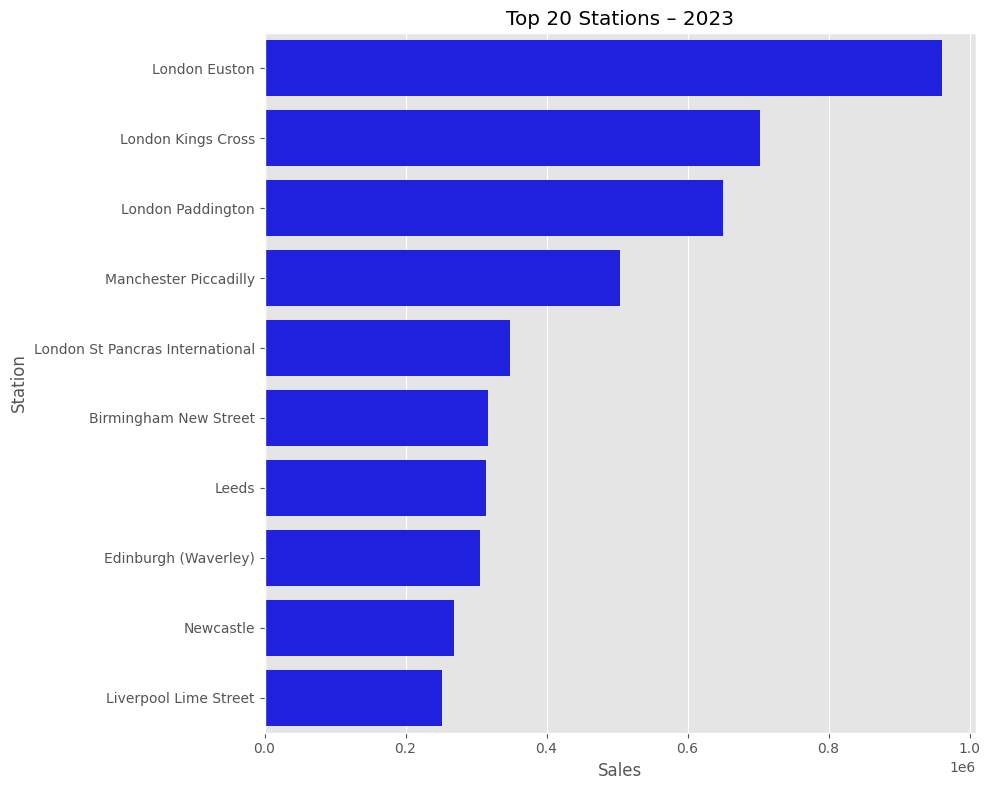

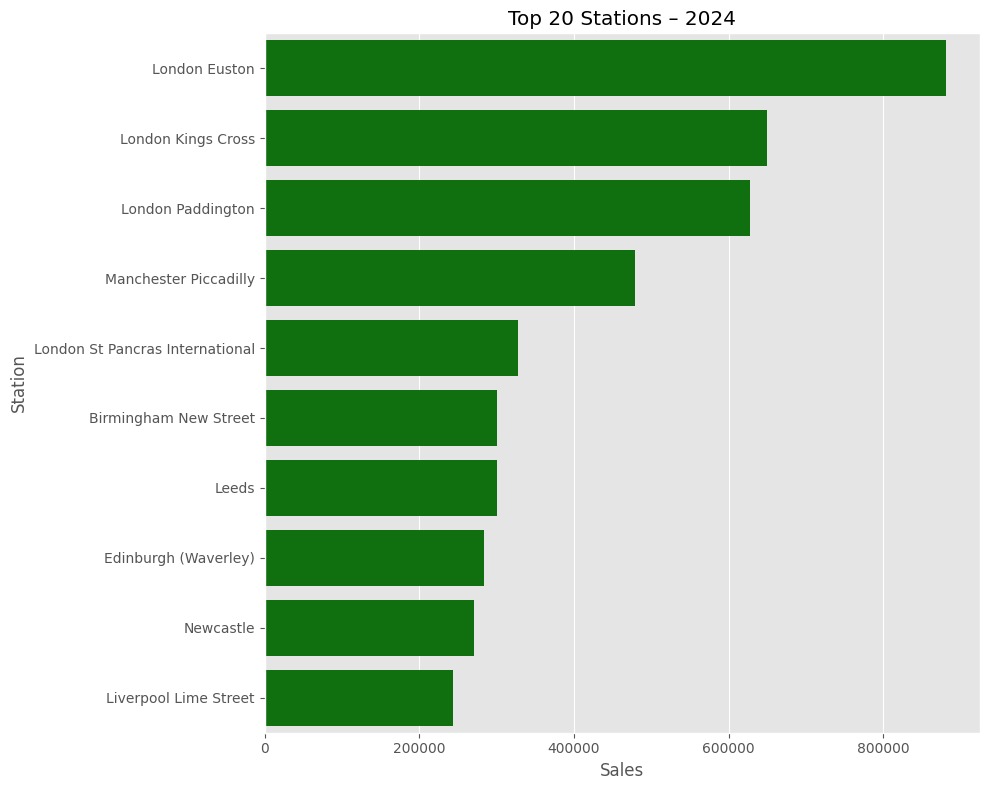

In [37]:
top_23 = (vis_df.query('year == 2023')
          .groupby('station', as_index=False)['sales']
          .sum()
          .sort_values('sales', ascending=False)
          .head(10))

top_24 = (vis_df.query('year == 2024')
          .groupby('station', as_index=False)['sales']
          .sum()
          .sort_values('sales', ascending=False)
          .head(10))

plt.figure(figsize=(10, 8))
sns.barplot(data=top_23, x='sales', y='station', color='blue')
plt.title('Top 20 Stations – 2023')
plt.xlabel('Sales')
plt.ylabel('Station')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.barplot(data=top_24, x='sales', y='station', color='green')
plt.title('Top 20 Stations – 2024')
plt.xlabel('Sales')
plt.ylabel('Station')
plt.tight_layout()
plt.show()


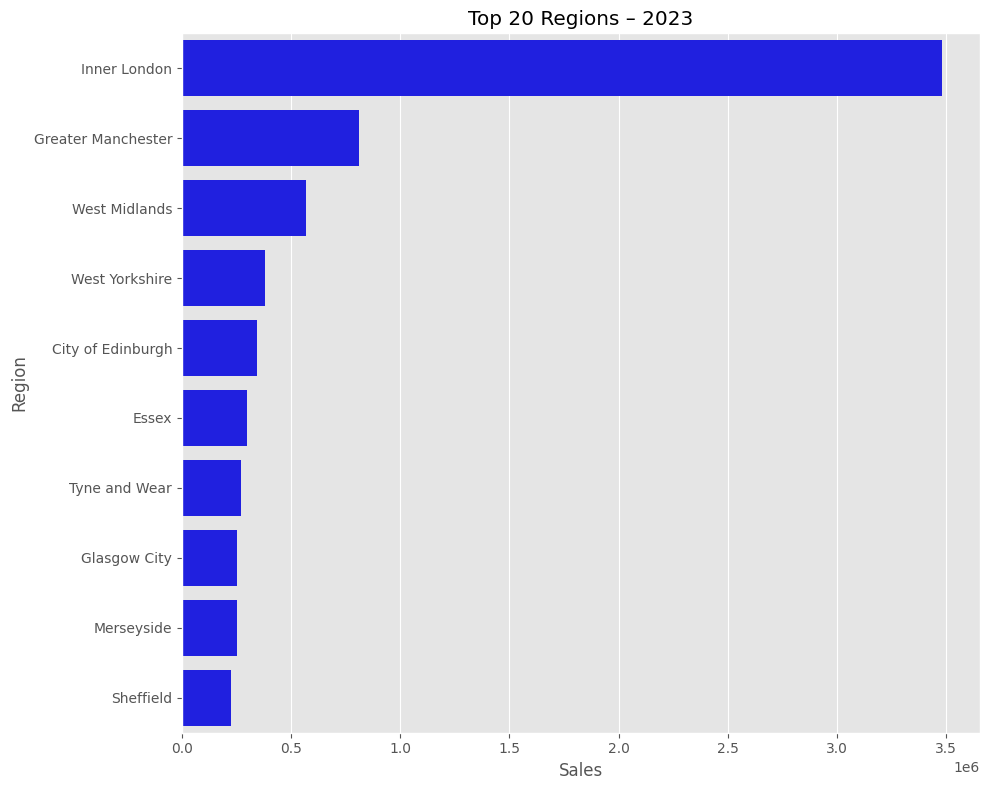

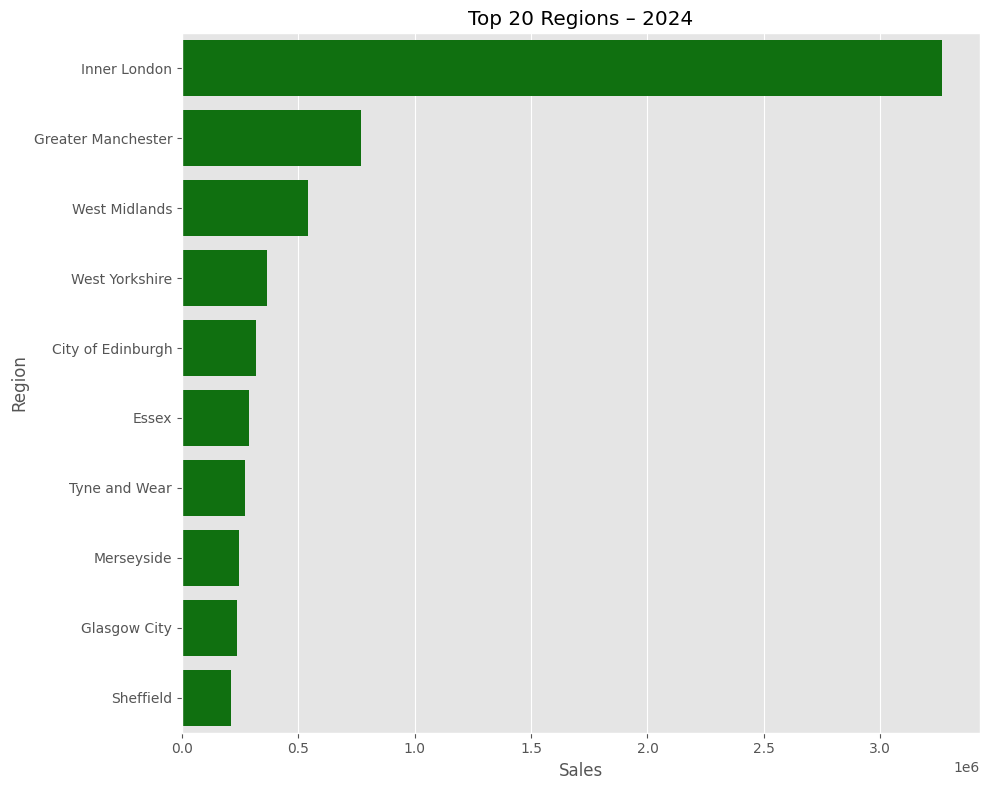

In [38]:
top_23 = (vis_df.query('year == 2023')
          .groupby('region', as_index=False)['sales']
          .sum()
          .sort_values('sales', ascending=False)
          .head(10))

top_24 = (vis_df.query('year == 2024')
          .groupby('region', as_index=False)['sales']
          .sum()
          .sort_values('sales', ascending=False)
          .head(10))

plt.figure(figsize=(10, 8))
sns.barplot(data=top_23, x='sales', y='region', color='blue')
plt.title('Top 20 Regions – 2023')
plt.xlabel('Sales')
plt.ylabel('Region')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.barplot(data=top_24, x='sales', y='region', color='green')
plt.title('Top 20 Regions – 2024')
plt.xlabel('Sales')
plt.ylabel('Region')
plt.tight_layout()
plt.show()


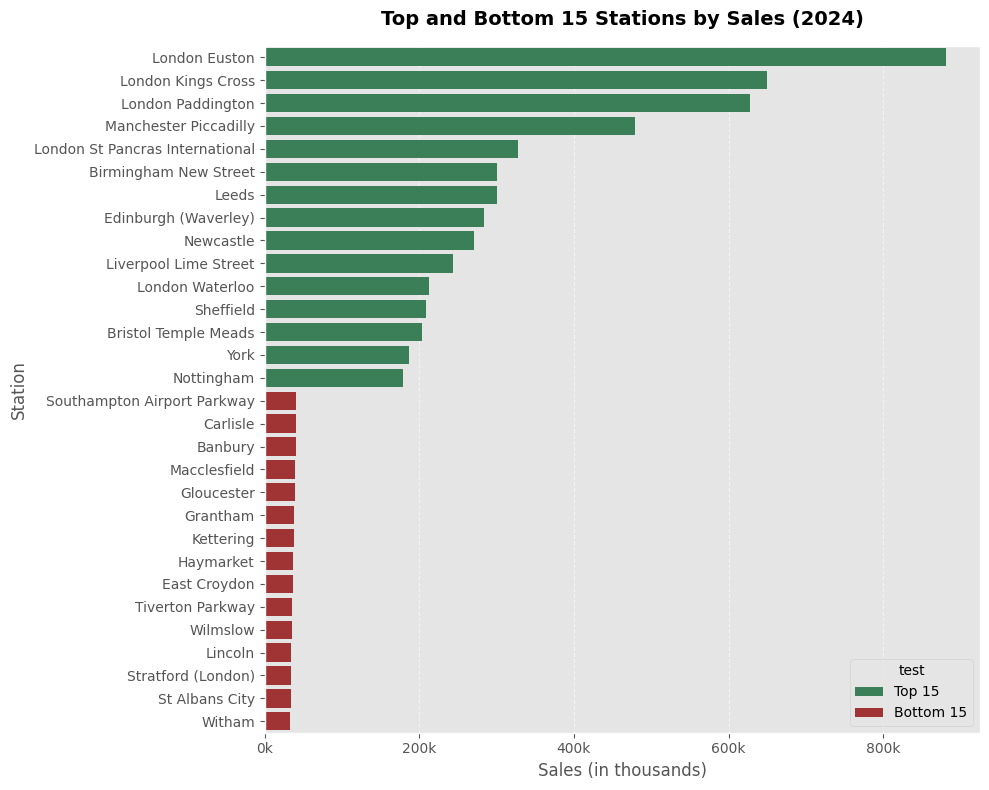

In [39]:
ranked_24 = (
    vis_df.query('year == 2024')
    .groupby('station', as_index=False)['sales']
    .sum()
    .sort_values('sales', ascending=False)
)

# Top and bottom 15
top15 = ranked_24.head(15).assign(rank_group='Top 15')
bot15 = ranked_24.tail(15).assign(rank_group='Bottom 15')
combined = pd.concat([top15, bot15])

combined['station'] = pd.Categorical(combined['station'], categories=combined['station'], ordered=True)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(
    data=combined,
    x='sales', y='station',
    hue='rank_group',
    dodge=False,
    palette={'Top 15': '#2e8b57', 'Bottom 15': '#b22222'}
)

from matplotlib.ticker import FuncFormatter
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x/1_000):,}k"))

plt.title('Top and Bottom 15 Stations by Sales (2024)', fontsize=14, weight='bold', pad=15)
plt.xlabel('Sales (in thousands)')
plt.ylabel('Station')
plt.legend(title='test', loc='lower right')
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


Stations: 100 | Top 20% count: 20
Top 20% sales: 12,659,506  (53.5%)
Bottom 80% sales: 11,001,685  (46.5%)


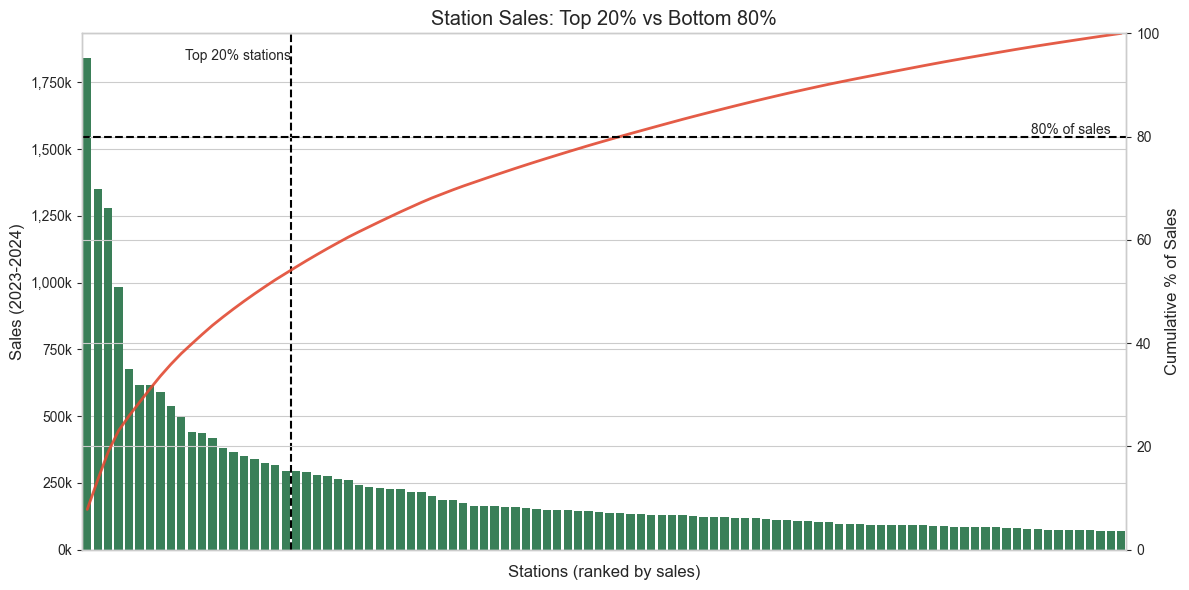

In [40]:
# Not quite paretos principle but definitly top heavy
top_24 = (
    vis_df
          .groupby("station", as_index=False)["sales"].sum()
          .sort_values("sales", ascending=False)
          .reset_index(drop=True)
)

top_24["rank"] = np.arange(1, len(top_24) + 1)
top_24["cum_sales"] = top_24["sales"].cumsum()
total_sales = top_24["sales"].sum()
top_24["cum_pct"] = top_24["cum_sales"] / total_sales * 100
top_24["station_pct"] = top_24["rank"] / len(top_24) * 100

n = len(top_24)
k = int(np.ceil(0.20 * n))                     
top20_sum = top_24.loc[:k-1, "sales"].sum()
bot80_sum = total_sales - top20_sum
top20_share = 100 * top20_sum / total_sales
bot80_share = 100 - top20_share

print(f"Stations: {n} | Top 20% count: {k}")
print(f"Top 20% sales: {top20_sum:,.0f}  ({top20_share:.1f}%)")
print(f"Bottom 80% sales: {bot80_sum:,.0f}  ({bot80_share:.1f}%)")

sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(12, 6))

sns.barplot(
    data=top_24,
    x="rank", y="sales",
    color="seagreen", ax=ax1, edgecolor="none"
)
ax1.set_xlabel("Stations (ranked by sales)")
ax1.set_ylabel("Sales (2023-2024)")
ax1.set_xticklabels([])
from matplotlib.ticker import FuncFormatter
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x/1_000):,}k"))
ax1.set_xlim(-0.5, n-0.5)

ax2 = ax1.twinx()
ax2.plot(top_24["rank"]-1, top_24["cum_pct"], linewidth=2, alpha=0.9)
ax2.set_ylabel("Cumulative % of Sales")
ax2.set_ylim(0, 100)


ax1.axvline(k-0.5, color="black", linestyle="--", linewidth=1.5)
ax2.axhline(80, color="black", linestyle="--", linewidth=1.5)
ax1.text(k-0.5, ax1.get_ylim()[1]*0.97, "Top 20% stations", ha="right", va="top")
ax2.text(n*0.98, 80, "80% of sales", ha="right", va="bottom")

plt.title("Station Sales: Top 20% vs Bottom 80%")
plt.tight_layout()
plt.show()


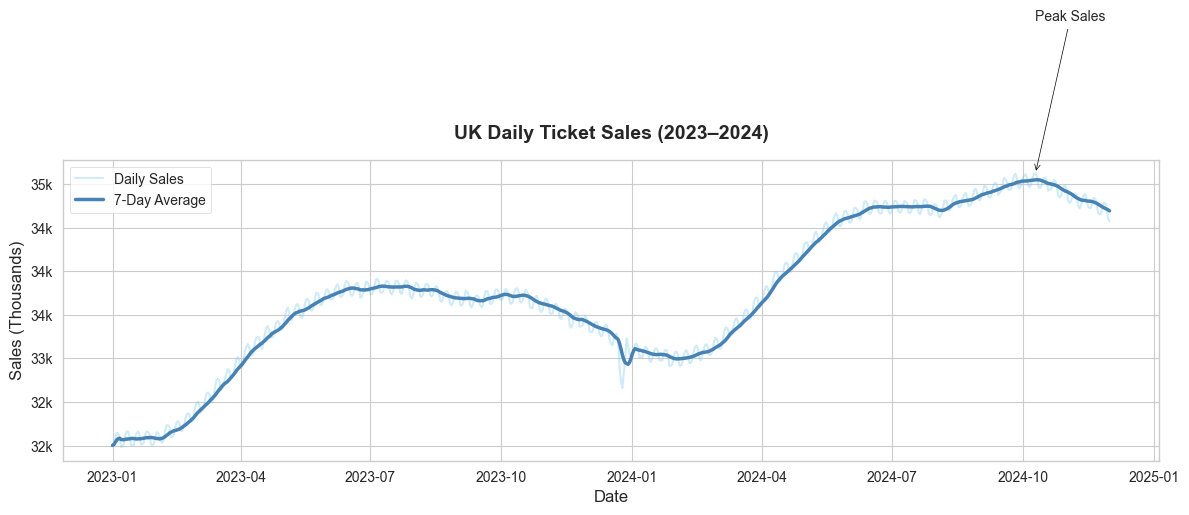

In [41]:
# ease
daily_sales = (
    vis_df.groupby('date', as_index=False)['sales']
    .sum()
    .sort_values('date')
)
daily_sales['7d_avg'] = daily_sales['sales'].rolling(7, min_periods=1).mean()

sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

sns.lineplot(
    data=daily_sales,
    x='date', y='sales',
    color='skyblue', alpha=0.4, linewidth=1.5,
    label='Daily Sales'
)

sns.lineplot(
    data=daily_sales,
    x='date', y='7d_avg',
    color='steelblue', linewidth=2.5,
    label='7-Day Average'
)

# Titles and labels
plt.title('UK Daily Ticket Sales (2023–2024)', fontsize=14, weight='bold', pad=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales (Thousands)', fontsize=12)

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1_000:.0f}k'))

max_date = daily_sales.loc[daily_sales['sales'].idxmax(), 'date']
max_val = daily_sales['sales'].max()
plt.annotate(
    'Peak Sales',
    xy=(max_date, max_val),
    xytext=(max_date, max_val*1.05),
    arrowprops=dict(arrowstyle='->', color='black'),
    fontsize=10
)

plt.legend(frameon=True, facecolor='white')
plt.tight_layout()
plt.show()


In [42]:
sales_variability = (
    vis_df.groupby('station')['sales']
    .agg(['std', 'mean', 'count'])
    .assign(cv=lambda x: x['std'] / x['mean'])
    .reset_index()
)

def level_changes(s):
    return (s != s.shift()).sum() - 1

sales_level_changes = (
    vis_df.groupby('station')['sales_level']
    .apply(level_changes)
    .reset_index(name='level_changes')
)

station_variability = sales_variability.merge(sales_level_changes, on='station', how='left')

/var/folders/nd/bjvm3cd953z10kb2c4z1rs4rnnf7fh/T/ipykernel_98754/801868976.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


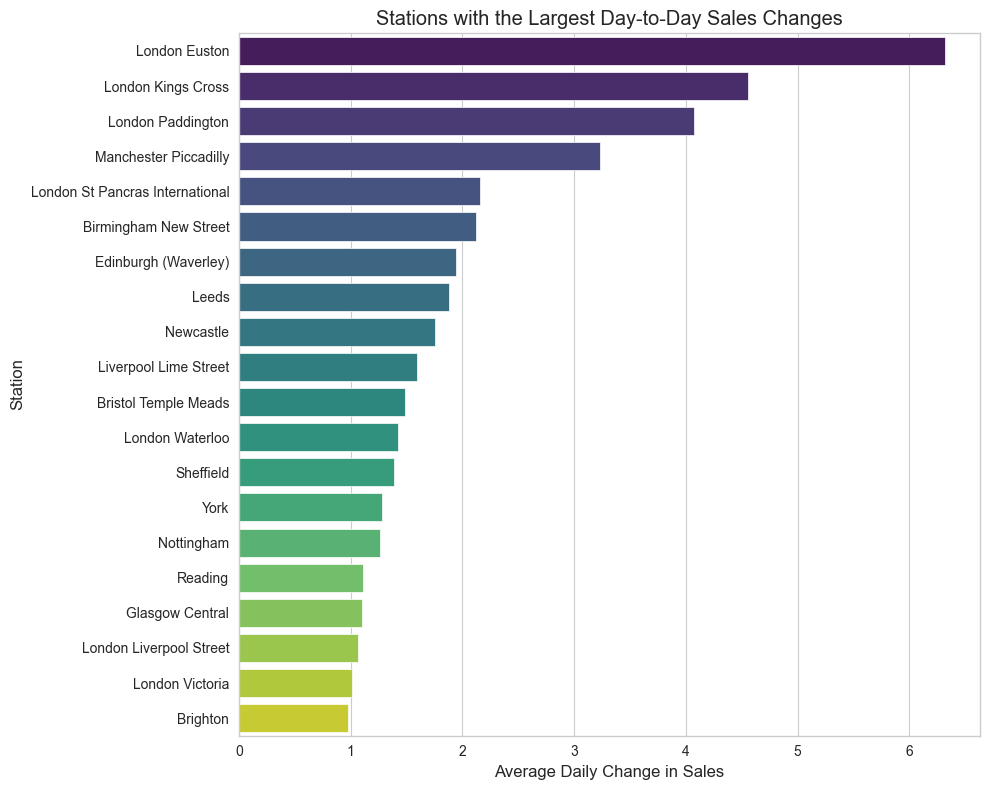

In [43]:
vis_df = vis_df.sort_values(['station', 'date'])
vis_df['daily_change'] = vis_df.groupby('station')['sales'].diff().abs()

station_changes = (
    vis_df.groupby('station')['daily_change']
    .mean()
    .reset_index(name='avg_daily_change')
    .sort_values('avg_daily_change', ascending=False)
)

top_changing_stations = station_changes.head(20)

plt.figure(figsize=(10, 8))
sns.barplot(
    data=top_changing_stations,
    y='station', x='avg_daily_change', palette='viridis'
)
plt.title('Stations with the Largest Day-to-Day Sales Changes')
plt.xlabel('Average Daily Change in Sales')
plt.ylabel('Station')
plt.tight_layout()
plt.show()


### Temporal Analysis

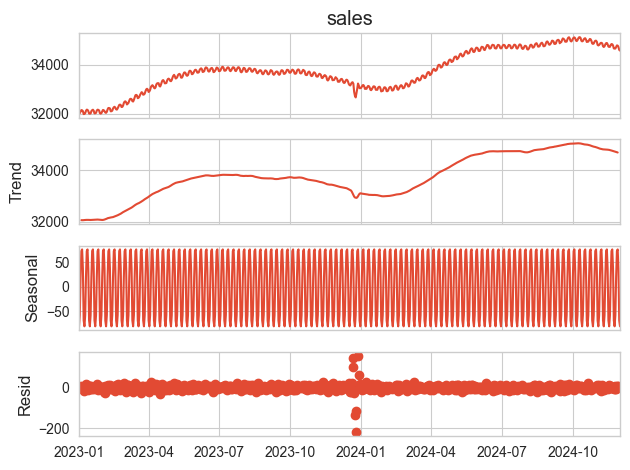

In [44]:
# Weekly Seasonal Decompose
total_sales = vis_df.groupby('date')['sales'].sum()
res = seasonal_decompose(total_sales, model='additive', period=7)
res.plot()
plt.show()


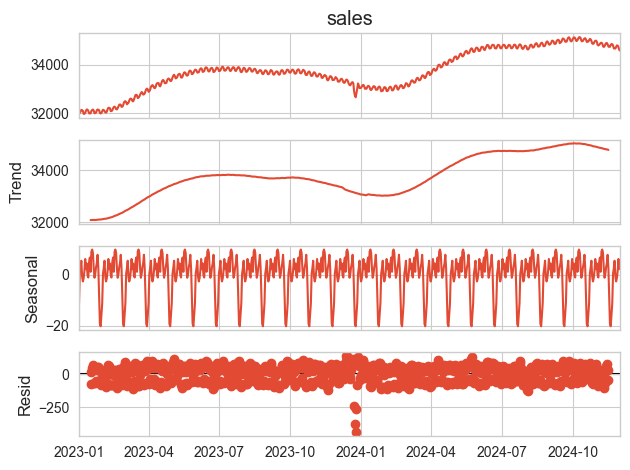

In [45]:
# Monthly Seasonal Decompose
total_sales = vis_df.groupby('date')['sales'].sum()
res = seasonal_decompose(total_sales, model='additive', period=30)
res.plot()
plt.show()


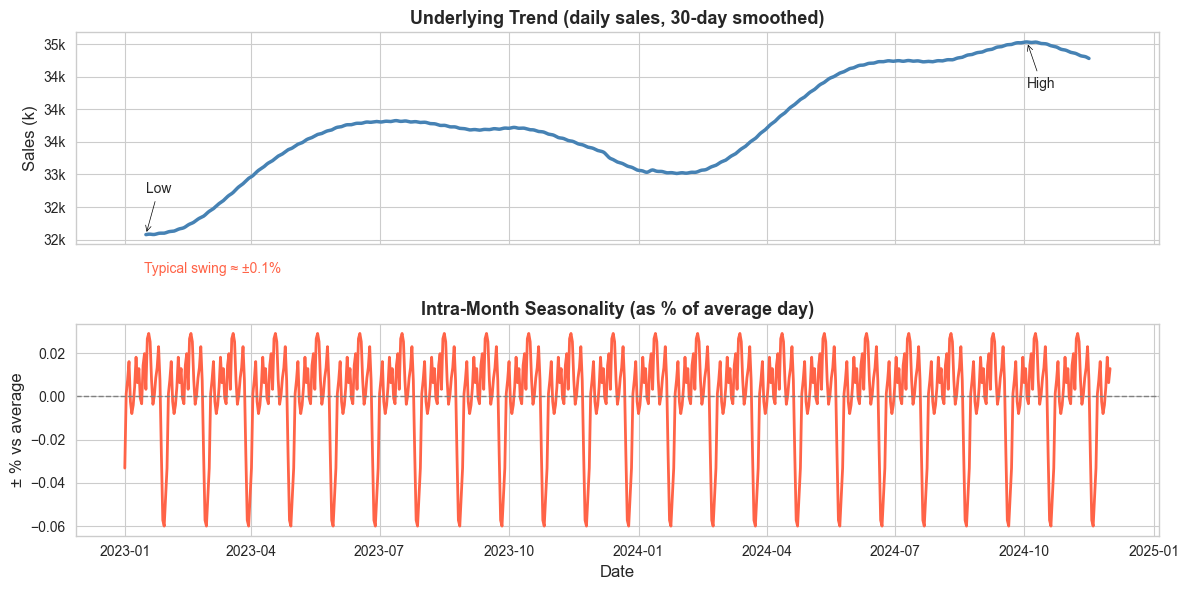

In [46]:
# rephrasing for slides
daily = vis_df.groupby('date', as_index=False)['sales'].sum().sort_values('date')
decomp = seasonal_decompose(daily.set_index('date')['sales'],
                            model='additive', period=30)

trend = decomp.trend
seasonal = decomp.seasonal

lvl = daily['sales'].mean()
seasonal_pct = 100 * seasonal / lvl

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
plt.subplots_adjust(hspace=0.25)

axes[0].plot(trend.index, trend.values, color='steelblue', linewidth=2.5)
axes[0].set_title("Underlying Trend (daily sales, 30-day smoothed)", fontsize=13, weight='bold')
axes[0].set_ylabel("Sales (k)")
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x/1_000:.0f}k"))

tmin = trend.idxmin(); tmax = trend.idxmax()
axes[0].annotate("Low", xy=(tmin, trend.loc[tmin]),
                 xytext=(tmin, trend.loc[tmin]*1.02),
                 arrowprops=dict(arrowstyle="->", color="black"))
axes[0].annotate("High", xy=(tmax, trend.loc[tmax]),
                 xytext=(tmax, trend.loc[tmax]*0.98),
                 arrowprops=dict(arrowstyle="->", color="black"))

axes[1].plot(seasonal_pct.index, seasonal_pct.values, color='tomato', linewidth=2)
axes[1].axhline(0, color='grey', linestyle='--', linewidth=1)
axes[1].set_title("Intra-Month Seasonality (as % of average day)", fontsize=13, weight='bold')
axes[1].set_ylabel("± % vs average")
axes[1].set_xlabel("Date")

amp = seasonal_pct.abs().quantile(0.95)
axes[1].text(seasonal_pct.index[int(len(seasonal_pct)*0.02)],
             amp, f"Typical swing ≈ ±{amp:.1f}%", color='tomato')

plt.tight_layout()
plt.show()


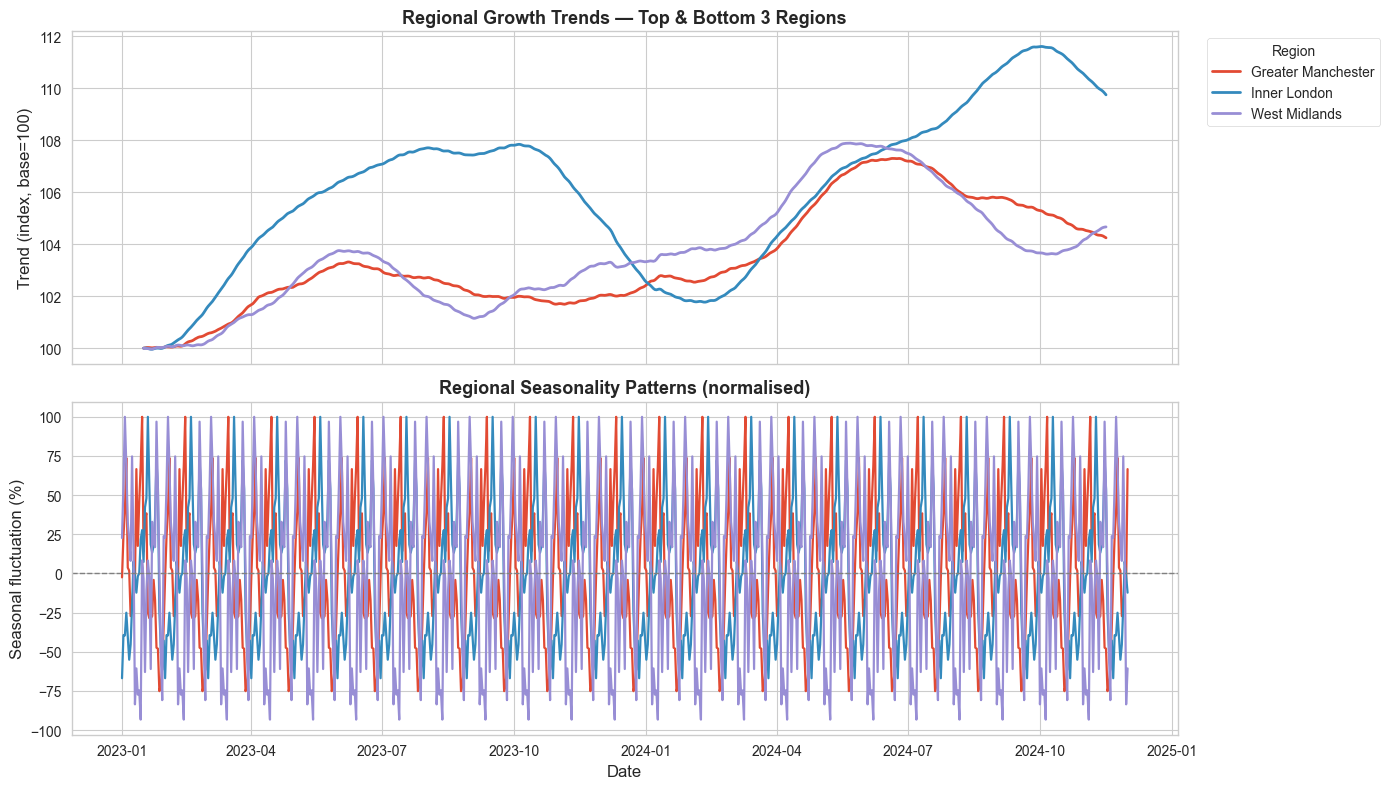

In [57]:
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Aggregate and rank regions by total sales ---
regional_daily = (
    vis_df.groupby(['region', 'date'], as_index=False)['sales']
          .sum()
          .sort_values(['region', 'date'])
)

region_totals = (
    regional_daily.groupby('region', as_index=False)['sales']
    .sum()
    .sort_values('sales', ascending=False)
)
top_regions = region_totals.head(3)['region'].tolist()
focus_regions = top_regions

regional_daily = regional_daily[regional_daily['region'].isin(focus_regions)]

# --- Seasonal decomposition per region ---
trend_list, seasonal_list = [], []

for region, grp in regional_daily.groupby('region'):
    if len(grp) < 60:
        continue
    res = seasonal_decompose(grp.set_index('date')['sales'], model='additive', period=30)
    tr = res.trend.reset_index().assign(region=region)
    se = res.seasonal.reset_index().assign(region=region)
    trend_list.append(tr)
    seasonal_list.append(se)

trend_df = pd.concat(trend_list, ignore_index=True).dropna(subset=['trend'])
seasonal_df = pd.concat(seasonal_list, ignore_index=True).dropna(subset=['seasonal'])

trend_df['trend_norm'] = trend_df.groupby('region')['trend'].transform(lambda x: 100 * x / x.iloc[0])
seasonal_df['seasonal_pct'] = seasonal_df.groupby('region')['seasonal'].transform(lambda x: 100 * x / x.abs().max())

trend_df = trend_df.drop_duplicates(subset=['region', 'date'])
seasonal_df = seasonal_df.drop_duplicates(subset=['region', 'date'])

# --- Plot ---
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
sns.lineplot(data=trend_df, x='date', y='trend_norm', hue='region', lw=2, ax=axes[0])
axes[0].set_title("Regional Growth Trends — Top & Bottom 3 Regions", fontsize=13, weight='bold')
axes[0].set_ylabel("Trend (index, base=100)")
axes[0].legend(title="Region", bbox_to_anchor=(1.02, 1), loc="upper left")

sns.lineplot(data=seasonal_df, x='date', y='seasonal_pct', hue='region', lw=1.6, ax=axes[1], legend=False)
axes[1].axhline(0, color='grey', ls='--', lw=1)
axes[1].set_title("Regional Seasonality Patterns (normalised)", fontsize=13, weight='bold')
axes[1].set_ylabel("Seasonal fluctuation (%)")
axes[1].set_xlabel("Date")

plt.tight_layout()
plt.show()


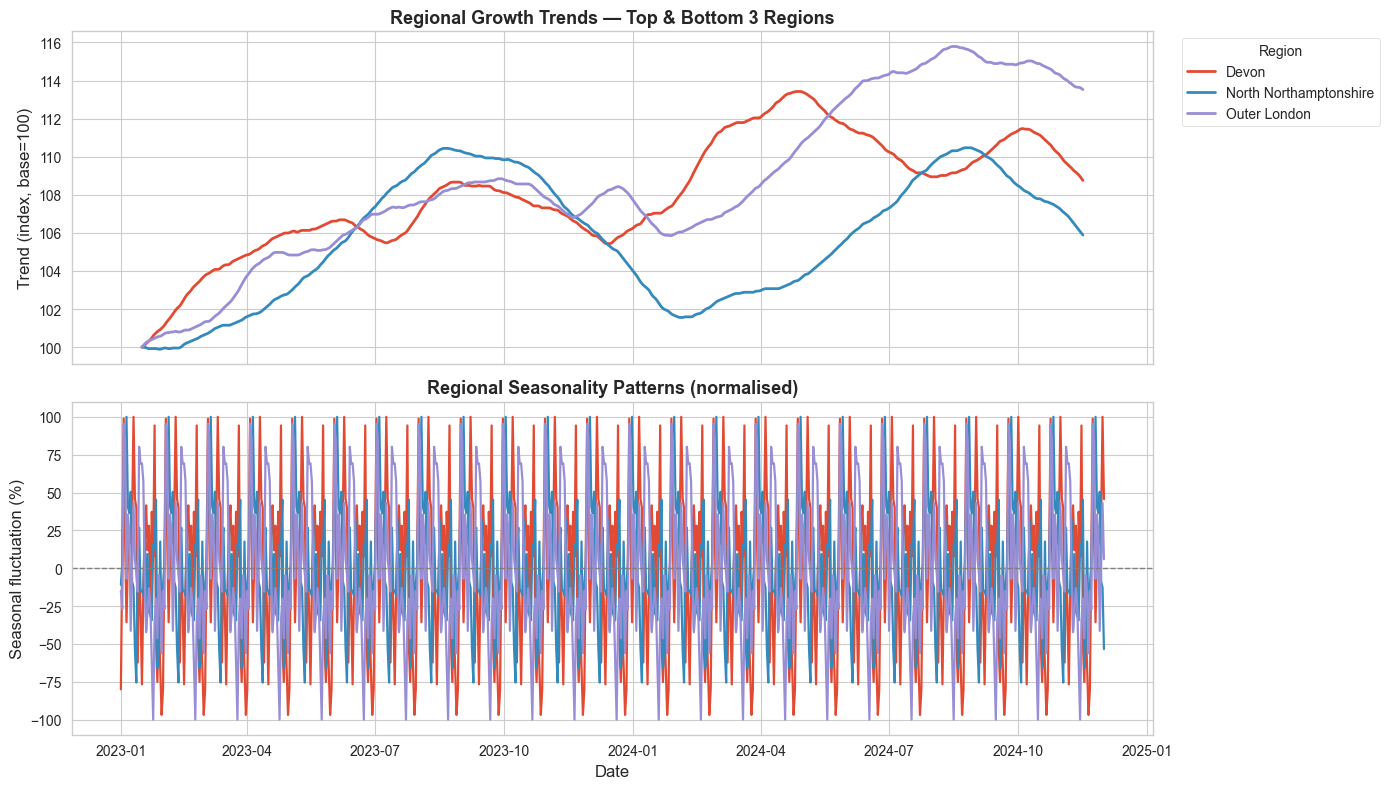

In [ ]:
regional_daily = (
    vis_df.groupby(['region', 'date'], as_index=False)['sales']
          .sum()
          .sort_values(['region', 'date'])
)

region_totals = (
    regional_daily.groupby('region', as_index=False)['sales']
    .sum()
    .sort_values('sales', ascending=False)
)
bottom_regions = region_totals.tail(3)['region'].tolist()
focus_regions = bottom_regions

regional_daily = regional_daily[regional_daily['region'].isin(focus_regions)]

trend_list, seasonal_list = [], []

for region, grp in regional_daily.groupby('region'):
    if len(grp) < 60:
        continue
    res = seasonal_decompose(grp.set_index('date')['sales'], model='additive', period=30)
    tr = res.trend.reset_index().assign(region=region)
    se = res.seasonal.reset_index().assign(region=region)
    trend_list.append(tr)
    seasonal_list.append(se)

trend_df = pd.concat(trend_list, ignore_index=True).dropna(subset=['trend'])
seasonal_df = pd.concat(seasonal_list, ignore_index=True).dropna(subset=['seasonal'])

trend_df['trend_norm'] = trend_df.groupby('region')['trend'].transform(lambda x: 100 * x / x.iloc[0])
seasonal_df['seasonal_pct'] = seasonal_df.groupby('region')['seasonal'].transform(lambda x: 100 * x / x.abs().max())

trend_df = trend_df.drop_duplicates(subset=['region', 'date'])
seasonal_df = seasonal_df.drop_duplicates(subset=['region', 'date'])


fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
sns.lineplot(data=trend_df, x='date', y='trend_norm', hue='region', lw=2, ax=axes[0])
axes[0].set_title("Regional Growth Trends — Top & Bottom 3 Regions", fontsize=13, weight='bold')
axes[0].set_ylabel("Trend (index, base=100)")
axes[0].legend(title="Region", bbox_to_anchor=(1.02, 1), loc="upper left")

sns.lineplot(data=seasonal_df, x='date', y='seasonal_pct', hue='region', lw=1.6, ax=axes[1], legend=False)
axes[1].axhline(0, color='grey', ls='--', lw=1)
axes[1].set_title("Regional Seasonality Patterns (normalised)", fontsize=13, weight='bold')
axes[1].set_ylabel("Seasonal fluctuation (%)")
axes[1].set_xlabel("Date")

plt.tight_layout()
plt.show()


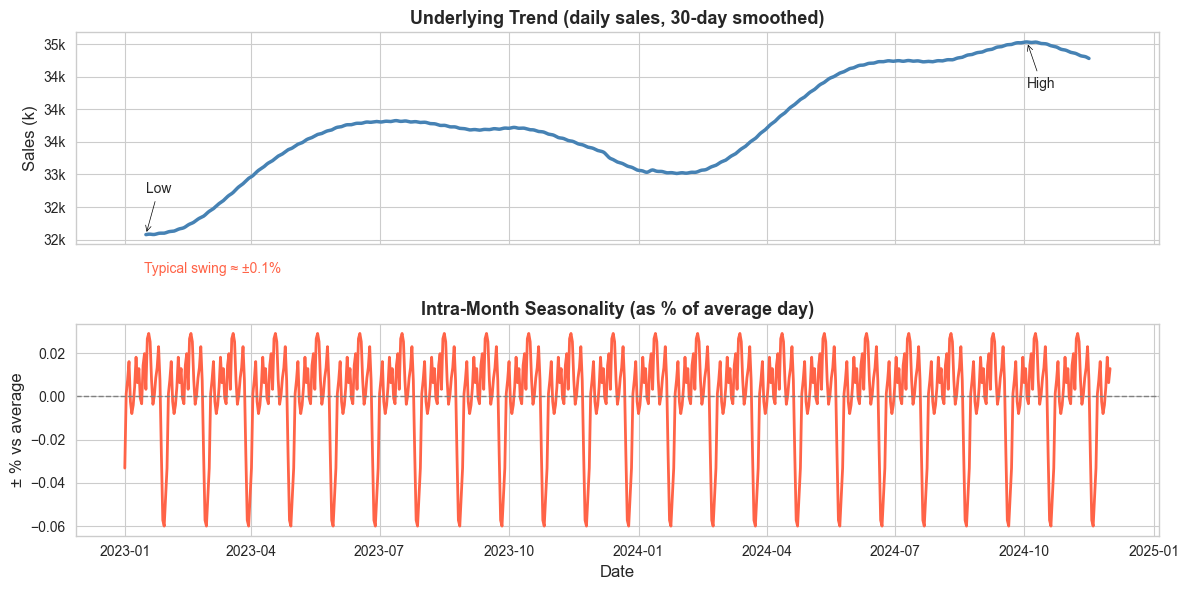

In [54]:
# rephrasing for slides
daily = vis_df.groupby('date', as_index=False)['sales'].sum().sort_values('date')
decomp = seasonal_decompose(daily.set_index('date')['sales'],
                            model='additive', period=30)

trend = decomp.trend
seasonal = decomp.seasonal

lvl = daily['sales'].mean()
seasonal_pct = 100 * seasonal / lvl

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
plt.subplots_adjust(hspace=0.25)

axes[0].plot(trend.index, trend.values, color='steelblue', linewidth=2.5)
axes[0].set_title("Underlying Trend (daily sales, 30-day smoothed)", fontsize=13, weight='bold')
axes[0].set_ylabel("Sales (k)")
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x/1_000:.0f}k"))

tmin = trend.idxmin(); tmax = trend.idxmax()
axes[0].annotate("Low", xy=(tmin, trend.loc[tmin]),
                 xytext=(tmin, trend.loc[tmin]*1.02),
                 arrowprops=dict(arrowstyle="->", color="black"))
axes[0].annotate("High", xy=(tmax, trend.loc[tmax]),
                 xytext=(tmax, trend.loc[tmax]*0.98),
                 arrowprops=dict(arrowstyle="->", color="black"))

axes[1].plot(seasonal_pct.index, seasonal_pct.values, color='tomato', linewidth=2)
axes[1].axhline(0, color='grey', linestyle='--', linewidth=1)
axes[1].set_title("Intra-Month Seasonality (as % of average day)", fontsize=13, weight='bold')
axes[1].set_ylabel("± % vs average")
axes[1].set_xlabel("Date")

amp = seasonal_pct.abs().quantile(0.95)
axes[1].text(seasonal_pct.index[int(len(seasonal_pct)*0.02)],
             amp, f"Typical swing ≈ ±{amp:.1f}%", color='tomato')

plt.tight_layout()
plt.show()


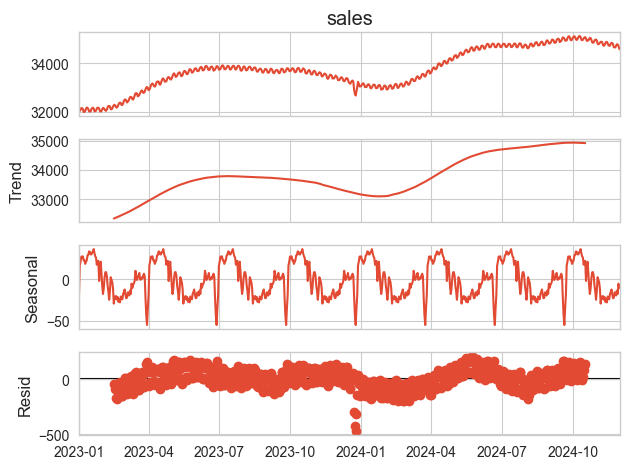

In [47]:
# Quartly Seasonal Decompose
total_sales = vis_df.groupby('date')['sales'].sum()
res = seasonal_decompose(total_sales, model='additive', period=90)
res.plot()
plt.show()


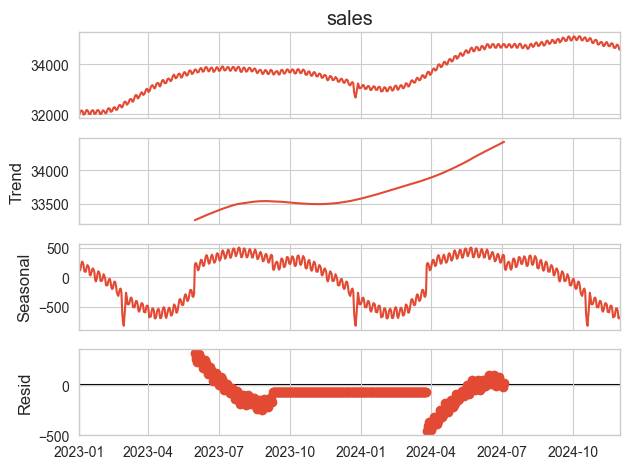

In [48]:
# Zoom out Seasonal Decompose
total_sales = vis_df.groupby('date')['sales'].sum()
res = seasonal_decompose(total_sales, model='additive', period=300)
res.plot()
plt.show()


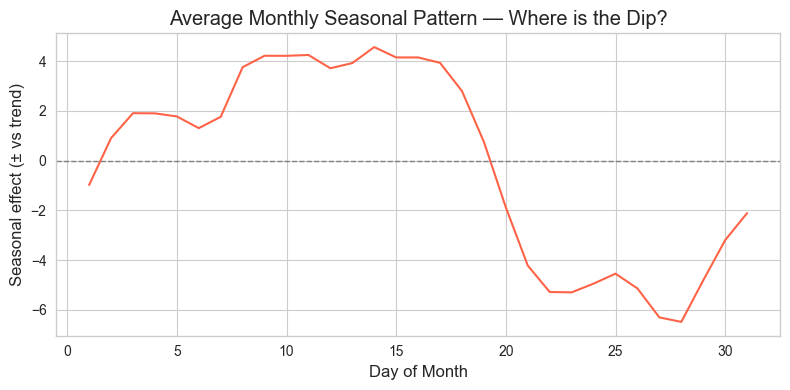

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Daily totals and decomposition (30 ~ “monthly” cycle)
daily = vis_df.groupby('date', as_index=False)['sales'].sum().sort_values('date')
res = seasonal_decompose(daily.set_index('date')['sales'], model='additive', period=30)

# 2) Seasonal component → DataFrame with a clear column name
seasonal = res.seasonal.reset_index(name='seasonal_effect')
seasonal['day_of_month'] = seasonal['date'].dt.day

# 3) Average seasonal pattern by day-of-month (this reveals the dip day)
avg_pattern = (
    seasonal.groupby('day_of_month', as_index=False)['seasonal_effect']
    .mean()
)

plt.figure(figsize=(8,4))
sns.lineplot(data=avg_pattern, x='day_of_month', y='seasonal_effect', color='tomato')
plt.title("Average Monthly Seasonal Pattern — Where is the Dip?")
plt.xlabel("Day of Month")
plt.ylabel("Seasonal effect (± vs trend)")
plt.axhline(0, color='grey', ls='--', lw=1)
plt.tight_layout()
plt.show()


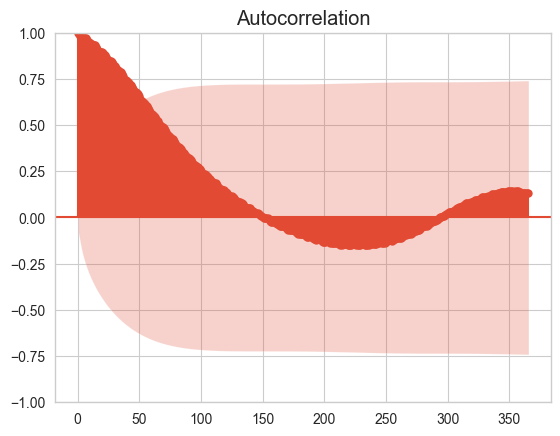

In [50]:
# Sales are correlated with recent sales.
# After 300 we see a rise in correlation again which is likely annual seasonality
plot_acf(vis_df.set_index('date').resample('D')['sales'].sum(), lags=365)
plt.show()

/var/folders/nd/bjvm3cd953z10kb2c4z1rs4rnnf7fh/T/ipykernel_98754/3120927946.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: seasonality_strength(g.set_index('date')['sales']))
/var/folders/nd/bjvm3cd953z10kb2c4z1rs4rnnf7fh/T/ipykernel_98754/3120927946.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


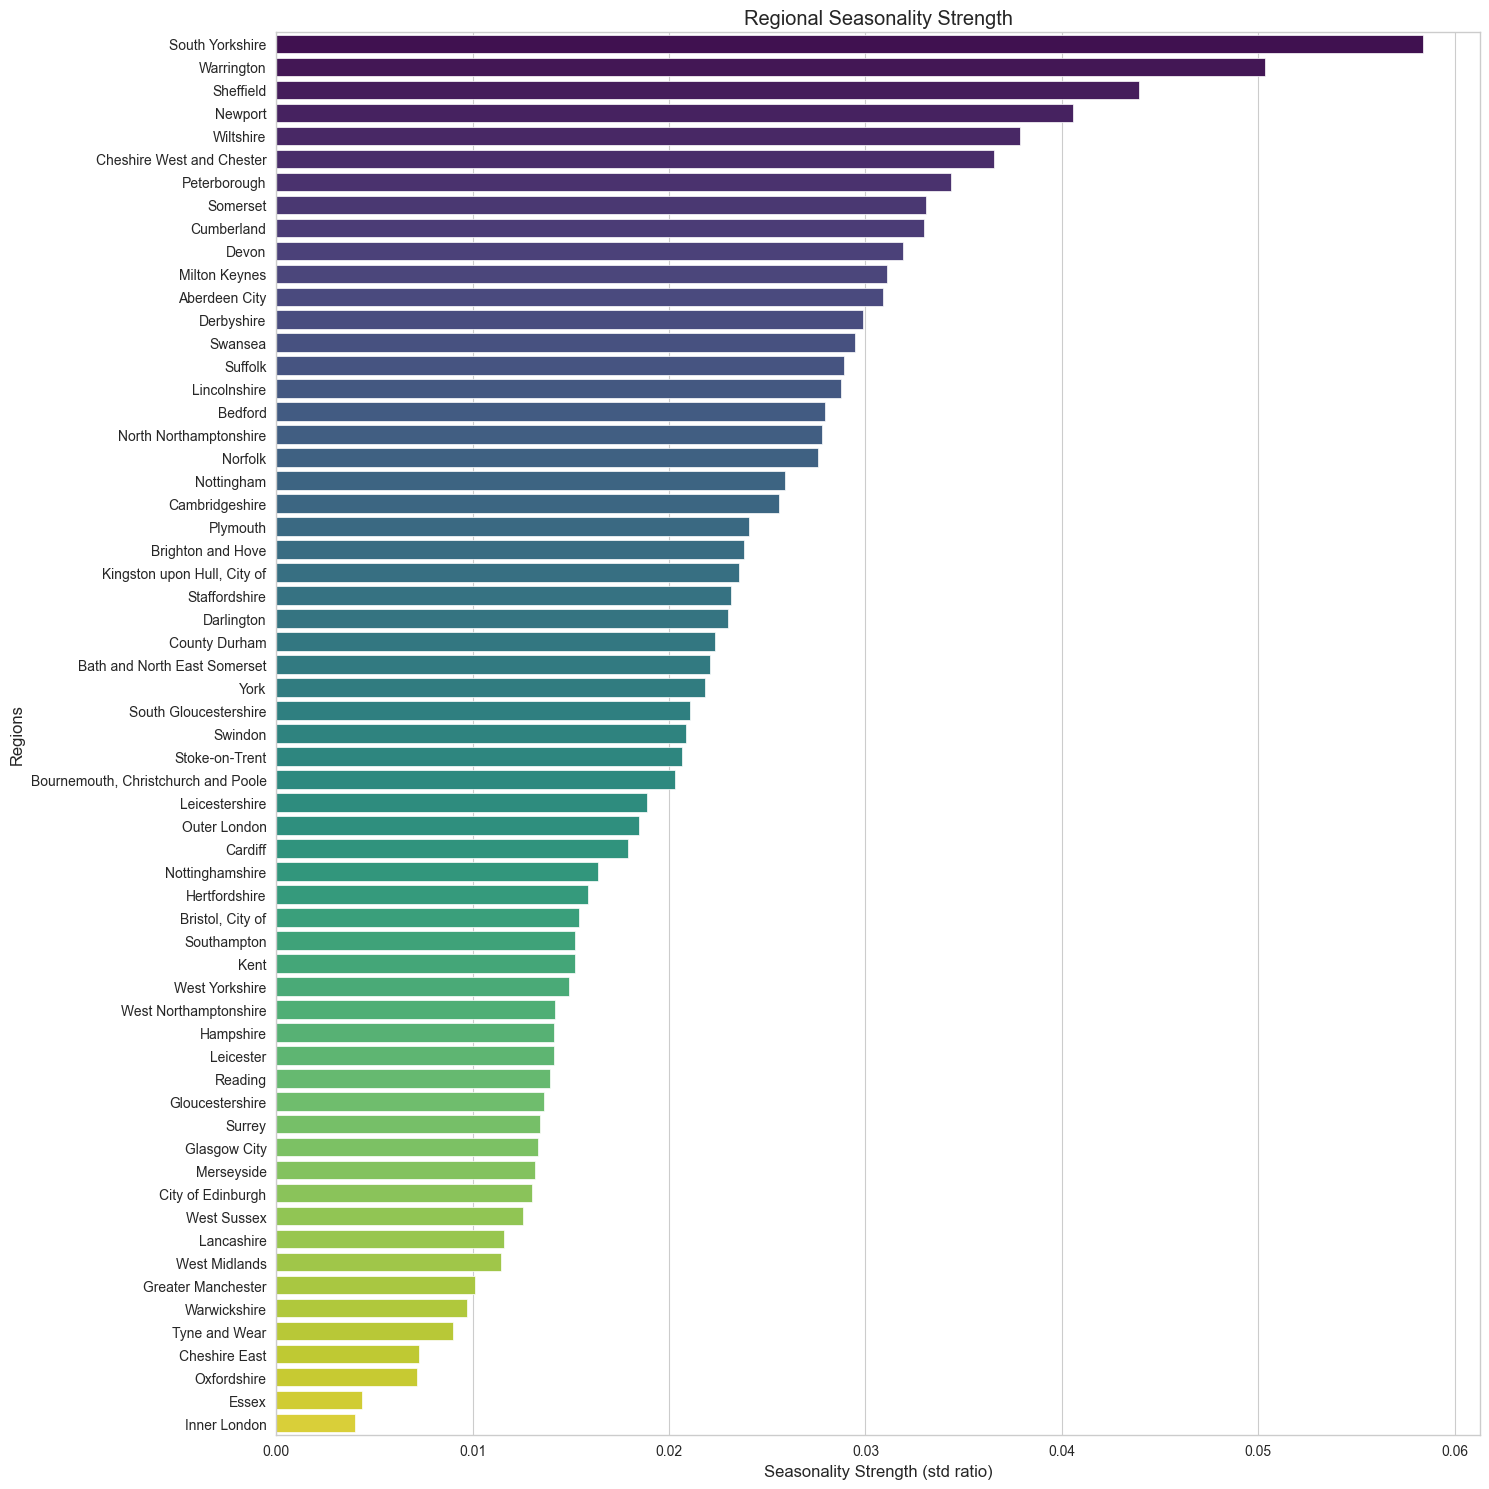

In [51]:
def seasonality_strength(series, period=30):
    from statsmodels.tsa.seasonal import seasonal_decompose
    res = seasonal_decompose(series, model='additive', period=period)
    return (res.seasonal.std() / series.std())

region_strength = (
    vis_df.groupby('region')
    .apply(lambda g: seasonality_strength(g.set_index('date')['sales']))
    .reset_index(name='seasonality_strength')
)

plt.figure(figsize=(15, 15))
sns.barplot(
    data=region_strength.sort_values('seasonality_strength', ascending=False),
    y='region', x='seasonality_strength', palette='viridis'
)
plt.xlabel('Seasonality Strength (std ratio)')
plt.ylabel('Regions')
plt.title('Regional Seasonality Strength')
plt.tight_layout()
plt.show()

# Locations at the top, nearly all deviations can be explained almost entirely by seasonality
# Locations at the likely have more steady sales.

/var/folders/nd/bjvm3cd953z10kb2c4z1rs4rnnf7fh/T/ipykernel_98754/2173468296.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: seasonality_strength(g.set_index("date")["sales"], period=30))
/var/folders/nd/bjvm3cd953z10kb2c4z1rs4rnnf7fh/T/ipykernel_98754/2173468296.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10, x="seasonality_strength", y="region", palette="viridis", ax=axes[0])


NameError: name 'PercentFormatter' is not defined

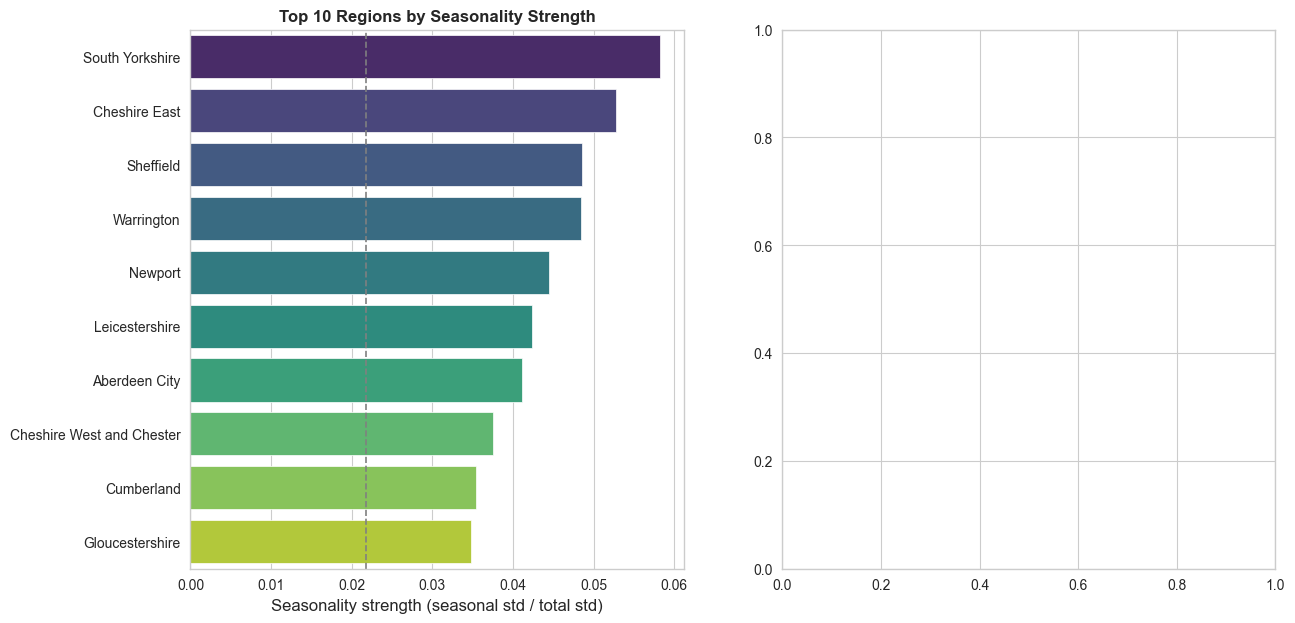

In [52]:
# Pretty versionfrom matplotlib.ticker import PercentFormatter

def seasonality_strength(series, period=30):
    s = series.dropna().sort_index()
    if len(s) < period * 2 or s.std() == 0:
        return np.nan
    res = seasonal_decompose(s, model="additive", period=period, extrapolate_trend="freq")
    return res.seasonal.std() / s.std()

daily_region = (
    vis_df.assign(date=pd.to_datetime(vis_df["date"]))
          .groupby(["region","date"], as_index=False)["sales"].sum()
)

region_strength = (
    daily_region.groupby("region")
    .apply(lambda g: seasonality_strength(g.set_index("date")["sales"], period=30))
    .rename("seasonality_strength")
    .reset_index()
    .dropna(subset=["seasonality_strength"])
)

ranked = region_strength.sort_values("seasonality_strength", ascending=False)
top10 = ranked.head(10).copy()
bot10 = ranked.tail(10).sort_values("seasonality_strength", ascending=True).copy()
median_strength = region_strength["seasonality_strength"].median()

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharex=False)

sns.barplot(data=top10, x="seasonality_strength", y="region", palette="viridis", ax=axes[0])
axes[0].axvline(median_strength, ls="--", lw=1.2, color="gray")
axes[0].set_title("Top 10 Regions by Seasonality Strength", fontsize=12, weight="bold")
axes[0].set_xlabel("Seasonality strength (seasonal std / total std)")
axes[0].set_ylabel("")
axes[0].xaxis.set_major_formatter(PercentFormatter(1.0))
for c in axes[0].containers:
    axes[0].bar_label(c, fmt=lambda v: f"{v:.1%}", padding=3)

sns.barplot(data=bot10, x="seasonality_strength", y="region", palette="mako_r", ax=axes[1])
axes[1].axvline(median_strength, ls="--", lw=1.2, color="gray")
axes[1].set_title("Bottom 10 Regions by Seasonality Strength", fontsize=12, weight="bold")
axes[1].set_xlabel("Seasonality strength (seasonal std / total std)")
axes[1].set_ylabel("")
axes[1].xaxis.set_major_formatter(PercentFormatter(1.0))
for c in axes[1].containers:
    axes[1].bar_label(c, fmt=lambda v: f"{v:.1%}", padding=3)

fig.suptitle("Regional Seasonality Strength (higher = sales driven more by seasonality)", fontsize=14, weight="bold")
fig.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(10, 8))
sns.lineplot(
    data=vis_df.query("station == 'Exeter St Davids'").groupby('date', as_index=False)['sales'].sum(),
    x='date', y='sales'
)
plt.title('Exeter Sales 2023 to 2024')
plt.xlabel('Date (days)')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()


### Distributions

In [ ]:
def diagnostic_sales(df, var):
    fig, axes = plt.subplots(1, 6, figsize=(20, 6))
    df[var] = pd.to_numeric(df[var], errors='coerce')

    sns.histplot(data=df, x=var, bins=40, hue="sales_level", ax=axes[0])
    axes[0].set_title(f"Distribution of {var}")

    stats.probplot(df[var], dist="norm", plot=axes[1])
    axes[1].set_ylabel("Quantiles")
    axes[1].set_title("Q-Q Plot (All Data)")

    high = df[df['sales_level'] == "High"]
    med = df[df['sales_level'] == "Medium"]
    low = df[df['sales_level'] == "Low"]

    sm.qqplot(high[var], line='s', ax=axes[2])
    axes[2].set_title(f"Q-Q Plot (High Sales))")

    sm.qqplot(med[var], line='s', ax=axes[3])
    axes[3].set_title(f"Q-Q Plot (Medium Sales))")

    sm.qqplot(low[var], line='s', ax=axes[4])
    axes[4].set_title(f"Q-Q Plot (Low Sales))")

    sns.boxplot(data=df, x="sales_level", y=var, ax=axes[5])
    axes[5].set_title("Boxplot")

    plt.show()

In [ ]:
vis_df.columns

In [ ]:
bool_cols = ['is_weekend', 'is_holiday']
vis_df[bool_cols] = vis_df[bool_cols].astype(int)

numeric_vars = vis_df[['date', 'sales', 'station', 'nation',
       'railway', 'year', 'month', 'day',
       'day_of_week', 'quarter', 'is_weekend', 'is_holiday', 'holiday_name',
       'local_authority', 'county', 'region', 'population', 'sales_per_capita',
       'sales_per_100k', 'sales_level', 'stations_in_region']].select_dtypes('number')
for var in numeric_vars:
    diagnostic_sales(vis_df, var)   

In [ ]:
# X = vis_df[['stations_in_region', 'population']]
# y = vis_df['sales']

# X = sm.add_constant(X)
# model = sm.OLS(y, X).fit()
# print(model.summary())


In [ ]:
top_10 = vis_df.groupby('station', as_index=False)['sales_per_capita'].mean().nlargest(10, 'sales_per_capita')
bottom_10 = vis_df.groupby('station', as_index=False)['sales_per_capita'].mean().nsmallest(10, 'sales_per_capita')

top_bot_10 = pd.concat([top_10.assign(rank_group='Top 10'), bottom_10.assign(rank_group='Bottom 10')])

# Plot
plt.figure(figsize=(10,6))
sns.barplot(
    data=top_bot_10, 
    x='sales_per_capita', 
    y='station', 
    hue='rank_group', 
    palette=['#2ca02c', '#d62728']
)
plt.title('Top and Bottom 10 Stations by Sales per Capita')
plt.xlabel('Sales per Capita')
plt.ylabel('Station')
plt.tight_layout()
plt.show()


In [ ]:
top_10 = vis_df.query("year == 2024").groupby('station', as_index=False)['sales'].sum().nlargest(15, 'sales')
bottom_10 = vis_df.query("year == 2024").groupby('station', as_index=False)['sales'].sum().nsmallest(15, 'sales')

top_bot_10 = pd.concat([top_10.assign(rank_group='Top 15'), bottom_10.assign(rank_group='Bottom 15')])

plt.figure(figsize=(10,6))
sns.barplot(
    data=top_bot_10, 
    x='sales', 
    y='station', 
    hue='rank_group', 
    palette=['#2ca02c', '#d62728']
)
plt.title('Top and Bottom 15 Stations by Sales 2024')
plt.xlabel('Sales')
plt.ylabel('Station')
plt.tight_layout()
plt.show()


In [ ]:
# import seaborn as sns
# sns.set_theme(style="ticks")

# sns.pairplot(vis_df[[numeric_vars]], hue="region")

think about station level as well. Regions will be biased to areas with more stations

***Key Visualisations***

    - A few stations drive the most sales (Pareto Principle)
    - Because of growth 2024 sales exceed 2023
    - Every ~3 months we see Peak-Valley-Peak patterns
    - Area with more population sell more tickets. They also tend to sell more per capita
    - Some smaller areas over perform for capita. London is dominant


## Modeling

***Modeling Ideas***

    - Predict highest networth / growth for a station in x months/years.
    - Short term - predict largest sales gain or total in x days.
    - Marketing campaigns to target workers? Travel between certain stations at a particular time will be workers, others tourists, others residents. A model cluster to categorise given a station/time of day/time of year a group to classify the majority as.

In [ ]:
# Dropping nation_by_sales_std_1d as well as 1d std is always 0
raw_df = station_sales_w_pop.copy()
raw_df = pd.DataFrame(raw_df.drop(columns=['geometry', 'source_operator', 'trainline_assisted_sales', 'region_geometry', 'lat', 'lon', 'nation_by_sales_std_1d'], inplace=False, errors='ignore'))

In [ ]:
raw_df.head()

### Adding More Features

In [ ]:
# Adding Fourier transformations to help represent the seasonal patterns
# and where the timestamp currently is in them
def add_fourier(df, date_col, period=365, order=3, desc=None):
    t = np.arange(len(df))
    for k in range(1, order+1):
        df[f'{desc}_sin_{k}'] = np.sin(2*np.pi*k*t/period)
        df[f'{desc}_cos_{k}'] = np.cos(2*np.pi*k*t/period)
    return df

raw_df = add_fourier(raw_df, date_col='date', period=7, order=3, desc='weekly')
raw_df = add_fourier(raw_df, date_col='date', period=30, order=3, desc='monthly')
raw_df = add_fourier(raw_df, date_col='date', period=120, order=3, desc='quartly')


In [ ]:
raw_df.shape

### Pipeline

In [ ]:
# raw_df = raw_df.sort_values(['station', 'date']).reset_index(drop=True)

# raw_df['cumsum'] = raw_df.groupby('station')['sales'].cumsum()
# raw_df['cumsum_fwd7'] = raw_df.groupby('station')['cumsum'].shift(-7)
# raw_df['cumsum_now']  = raw_df['cumsum']
# raw_df['target_next7'] = raw_df['cumsum_fwd7'] - raw_df['cumsum_now']

# raw_df['cumsum_fwd90'] = raw_df.groupby('station')['cumsum'].shift(-90)
# raw_df['cumsum_now']  = raw_df['cumsum']
# raw_df['target_next90'] = raw_df['cumsum_fwd90'] - raw_df['cumsum_now']


# max_lag = 28  # your largest lag/rolling window size

# def drop_warmup_and_tail(df, group='station', warm=max_lag, tail=7):
#     df = df.sort_values([group, 'date'])
#     # per-group slice: keep rows with full history AND full future target
#     return (df.groupby(group, group_keys=False)
#               .apply(lambda x: x.iloc[warm:len(x)-tail])
#               .reset_index(drop=True))

# filtered_raw_df = drop_warmup_and_tail(raw_df)

# filtered_raw_df = filtered_raw_df.drop(columns=['cumsum','cumsum_fwd7','cumsum_now'], errors='ignore')


In [ ]:
# Swapped to predicting a day of sales
# doing a sum of sales over a period smoothed it out to much
# and affected predictions.
# harder to see errors
raw_df = raw_df.sort_values(['station', 'date']).reset_index(drop=True)

for horizon in [7, 30, 90]:
    raw_df[f'target_next{horizon}'] = raw_df.groupby('station')['sales'].shift(-horizon)

max_lag = 28

def drop_warmup_and_tail(df, group='station', warm=max_lag, tail=90):
    df = df.sort_values([group, 'date'])
    return (df.groupby(group, group_keys=False)
              .apply(lambda x: x.iloc[warm:len(x)-tail])
              .reset_index(drop=True))

filtered_raw_df = drop_warmup_and_tail(raw_df)


#### PARAMETERS

In [ ]:
filtered_raw_df.head()

In [ ]:
# Parameters to swap into models
TARGET7 = "target_next7"
TARGET30 = "target_next30"
TARGET90 = "target_next90"

DATE = "date"
GROUP_COL = "station"

y = filtered_raw_df[TARGET7]
X = filtered_raw_df.drop(columns=["authority_code", TARGET7, TARGET30, TARGET90, DATE], errors="ignore")

y30 = filtered_raw_df[TARGET30]
X30 = filtered_raw_df.drop(columns=["authority_code", TARGET7, TARGET30, TARGET90, DATE], errors="ignore")

y90 = filtered_raw_df[TARGET90]
X90 = filtered_raw_df.drop(columns=["authority_code", TARGET90, TARGET30, TARGET7, DATE], errors="ignore")

CAT_COLS = [
    c for c in X.columns
    if (X[c].dtype == "object" or str(X[c].dtype) == "category")
    and c != GROUP_COL
]
NUM_COLS = [c for c in X.columns if c not in CAT_COLS]


In [ ]:
# Processor to clean columns
preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median", add_indicator=True)),
        ("scaler", StandardScaler())
    ]), NUM_COLS),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]), CAT_COLS),
])

### Scikit-learn

In [ ]:
# Computational slow the last 2
# Moved onto other models
models = {
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001, max_iter=5000),
    "RandomForest": RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1),
    "HistGB": HistGradientBoostingRegressor(random_state=42),
    # "SVR": SVR(kernel="rbf", C=10.0, epsilon=0.1),
    # "KNN": KNeighborsRegressor(n_neighbors=10)
}

In [ ]:
# import warnings
# warnings.filterwarnings(
#     "ignore",
#     message="Skipping features without any observed values"
# )

# rmse_scorer = make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), greater_is_better=False)
# mae_scorer  = make_scorer(mean_absolute_error, greater_is_better=False)
# r2_scorer   = make_scorer(r2_score)


# tscv = TimeSeriesSplit(n_splits=3)

# results = []
# for name, model in models.items():
#     pipe = Pipeline([
#         ("preprocessor", preprocessor),
#         ("model", model)
#     ])

#     cv = cross_validate(
#         pipe, X, y, cv=tscv, n_jobs=-1,
#         scoring={"rmse": rmse_scorer, "mae": mae_scorer, "r2": r2_scorer}
#     )

#     results.append({
#         "model": name,
#         "RMSE": -cv["test_rmse"].mean(),
#         "MAE": -cv["test_mae"].mean(),
#         "R2": cv["test_r2"].mean()
#     })

# leaderboard = pd.DataFrame(results).sort_values("RMSE").reset_index(drop=True)
# leaderboard


In [ ]:
# with open("scikit-learn_leaderboard.yaml", "w") as f:
#      yaml.dump(leaderboard.set_index("model").to_dict(orient="index"), f)


### Xgboost

In [ ]:
filtered_raw_df = filtered_raw_df.sort_values([GROUP_COL, DATE])
split_date = filtered_raw_df[DATE].quantile(0.8)
train_mask = filtered_raw_df[DATE] <= split_date
test_mask  = ~train_mask

bool_cols = X30.select_dtypes(include=["bool"]).columns.tolist()
X30[bool_cols] = X30[bool_cols].astype(int)

cat_cols  = X30.select_dtypes(include=["object", "category"]).columns.tolist()

cat_cols  = [c for c in cat_cols if c != GROUP_COL]

num_cols  = X30.select_dtypes(include=[np.number]).columns.tolist()

num_cols  = [c for c in num_cols if c not in []]

bad_in_num = [c for c in num_cols if X30[c].dtype.kind not in "iuufc"]  # not numeric
if bad_in_num:
    raise TypeError(f"Non-numeric columns in num_cols: {bad_in_num}")


preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median", add_indicator=True)),
        ("scaler", StandardScaler())
    ]), num_cols),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]), cat_cols),
], remainder="drop")


xgb_model = XGBRegressor(
    n_estimators=600, learning_rate=0.05, max_depth=6,
    subsample=0.9, colsample_bytree=0.8, tree_method="hist",
    objective="reg:squarederror", random_state=42, n_jobs=-1
)

pipe = Pipeline([
    ("pre", preprocessor),
    ("model", TransformedTargetRegressor(
        regressor=xgb_model,
        func=np.log1p, inverse_func=np.expm1
    ))
])

X_train, X_test = X.loc[train_mask], X.loc[test_mask]
y_train, y_test = y.loc[train_mask], y.loc[test_mask]

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred)

print(f"MAE: {mae:,.2f} | RMSE: {rmse:,.2f} | R²: {r2:.3f}")

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual target_next7")
plt.ylabel("Predicted target_next7")
plt.title("Predicted vs Actual")
plt.tight_layout()
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(7,4))
sns.histplot(residuals, kde=True)
plt.axvline(0, color="red", linestyle="--")
plt.title("Residual Distribution")
plt.xlabel("Error (Actual - Predicted)")
plt.tight_layout()
plt.show()

final_model = pipe.named_steps["model"].regressor_
plt.figure(figsize=(10,6))
from xgboost import plot_importance
plot_importance(final_model, max_num_features=15, importance_type="gain")
plt.title("Top Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()

In [ ]:
# Create a copy of the test data with actual and predicted values
plot_df = (
    filtered_raw_df.loc[test_mask, [GROUP_COL, DATE, TARGET30]]
    .assign(predicted=y_pred)
    .rename(columns={TARGET30: "actual"})
)


In [ ]:
station_sample = plot_df[plot_df[GROUP_COL] == "London Waterloo"]

plt.figure(figsize=(12, 5))
plt.plot(station_sample[DATE], station_sample["actual"], label="Actual", color="black", linewidth=2)
plt.plot(station_sample[DATE], station_sample["predicted"], label="Predicted", color="orange", linewidth=2, alpha=0.8)
plt.title(f"{GROUP_COL}: London Waterloo – Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
vis_df.region.value_counts().tail(20)

In [ ]:
vis_df.query("region == 'Bedford'")

In [ ]:
station_sample = plot_df[plot_df[GROUP_COL] == "Bedford"]

plt.figure(figsize=(12, 5))
plt.plot(station_sample[DATE], station_sample["actual"], label="Actual", color="black", linewidth=2)
plt.plot(station_sample[DATE], station_sample["predicted"], label="Predicted", color="orange", linewidth=2, alpha=0.8)
plt.title(f"{GROUP_COL}: Bedford – Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
station_sample = plot_df[plot_df[GROUP_COL] == "London Euston"]

plt.figure(figsize=(12, 5))
plt.plot(station_sample[DATE], station_sample["actual"], label="Actual", color="black", linewidth=2)
plt.plot(station_sample[DATE], station_sample["predicted"], label="Predicted", color="orange", linewidth=2, alpha=0.8)
plt.title(f"{GROUP_COL}: London Euston – Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Looking at this example I don't see anything particulary which would start the sudden drop i.e. holiday.
filtered_raw_df.query(
    "(date > '2024-07-22') and (date < '2024-07-25') and (station == 'London Euston')"
)


In [ ]:
region_name = "Inner London"

region_plot_df = (
    filtered_raw_df.loc[test_mask, [GROUP_COL, "region", DATE]]
    .assign(actual=y_test, predicted=y_pred)
)
region_plot_df = region_plot_df[region_plot_df["region"] == region_name]

# Normalise per station
region_plot_df["actual_norm"] = region_plot_df.groupby(GROUP_COL)["actual"].transform(lambda x: x / x.mean())
region_plot_df["predicted_norm"] = region_plot_df.groupby(GROUP_COL)["predicted"].transform(lambda x: x / x.mean())

region_avg = (
    region_plot_df.groupby(DATE)[["actual_norm", "predicted_norm"]]
    .mean()
    .reset_index()
)

plt.figure(figsize=(14,7))
for stn, sub in region_plot_df.groupby(GROUP_COL):
    plt.plot(sub[DATE], sub["predicted_norm"], color="orange", linewidth=1, alpha=0.4)

plt.plot(region_avg[DATE], region_avg["actual_norm"], color="black", linewidth=2.5, label="Actual (Region Avg)")
plt.plot(region_avg[DATE], region_avg["predicted_norm"], color="dodgerblue", linewidth=2.5, label="Predicted (Region Avg)")
plt.title(f"Region: {region_name} — Station-Level Normalised Predictions vs Regional Average")
plt.xlabel("Date")
plt.ylabel("Relative Sales (vs station mean = 1.0)")
plt.legend()
plt.tight_layout()
plt.show()


### Prophet

In [ ]:
HORIZON = 30  # evaluate & forecast 30 days ahead

station_id = "London Paddington"

grp = (
    filtered_raw_df.query(f"{GROUP_COL} == @station_id")[ [DATE, TARGET30] ]
    .rename(columns={DATE: "ds", TARGET30: "y"})
    .sort_values("ds")
)

if len(grp) > 2 * HORIZON:
    train = grp.iloc[:-HORIZON]
    test  = grp.iloc[-HORIZON:]

    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode="additive",
        changepoint_prior_scale=0.15,
    )
    m.fit(train)

    future   = m.make_future_dataframe(periods=HORIZON, freq="D")
    forecast = m.predict(future)

    # plot: train/test + future-only forecast
    plt.figure(figsize=(10, 5))
    plt.plot(train["ds"], train["y"], label="Train (actual)", color="tab:blue")
    plt.plot(test["ds"],  test["y"],  label="Test (actual)",  color="black")
    fc_future = forecast.tail(HORIZON)
    plt.plot(fc_future["ds"], fc_future["yhat"], label="Forecast (next 30d)", color="tab:orange")
    plt.title(f"Prophet Forecast — {station_id} (Target = {TARGET30})")
    plt.ylabel("Sales (t+30)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    m.plot_components(forecast)
    plt.suptitle(f"Prophet Components — {station_id}", y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print(f"Skipping {station_id} (too short series)")


In [ ]:
station_id   = "London Paddington"
TARGET_COL   = "target_next30"
DATE_COL     = "date"
GROUP_COL    = "station"
train_cutoff = pd.Timestamp("2024-03-01")
forecast_end = pd.Timestamp("2024-12-31")

grp = (
    filtered_raw_df
      .query(f"{GROUP_COL} == @station_id")[ [DATE_COL, TARGET_COL] ]
      .rename(columns={DATE_COL: "ds", TARGET_COL: "y"})
      .sort_values("ds")
      .dropna(subset=["y"])
)
grp["ds"] = pd.to_datetime(grp["ds"])

train = grp[grp["ds"] < train_cutoff]
test  = grp[(grp["ds"] >= train_cutoff) & (grp["ds"] <= forecast_end)]

if len(train) < 60:
    raise ValueError("Not enough history before 2024-03 for reliable training.")

m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode="additive",
    changepoint_prior_scale=0.15,
)
m.fit(train)

horizon_days = (forecast_end - train["ds"].max()).days
future = m.make_future_dataframe(periods=horizon_days, freq="D")
fcst  = m.predict(future)

fcst_window = fcst[(fcst["ds"] >= train_cutoff) & (fcst["ds"] <= forecast_end)][["ds","yhat","yhat_lower","yhat_upper"]]

eval_df = test.merge(fcst_window, on="ds", how="inner")
if not eval_df.empty:
    mae  = mean_absolute_error(eval_df["y"], eval_df["yhat"])
    rmse = np.sqrt(mean_squared_error(eval_df["y"], eval_df["yhat"]))
else:
    mae = rmse = np.nan

print(f"{station_id} — Prophet on {TARGET_COL}")
print(f"Train: < {train_cutoff.date()}  |  Test/Forecast: {train_cutoff.date()} .. {forecast_end.date()}")
print(f"MAE: {mae:,.2f} | RMSE: {rmse:,.2f}")

plt.figure(figsize=(12,6))
plt.plot(train["ds"], train["y"], label="Train (actual)", color="tab:blue", linewidth=2, alpha=0.9)
if not test.empty:
    plt.plot(test["ds"],  test["y"],  label="Test (actual)",  color="black", linewidth=2, alpha=0.8)
plt.plot(fcst_window["ds"], fcst_window["yhat"], label="Forecast (to 2024-12-31)", color="tab:orange", linewidth=2)
plt.fill_between(fcst_window["ds"], fcst_window["yhat_lower"], fcst_window["yhat_upper"], color="tab:orange", alpha=0.15, label="Forecast CI")
plt.axvline(train_cutoff, color="gray", linestyle="--", alpha=0.7)
plt.title(f"Prophet Forecast — {station_id} (Train to 2024-03, Predict rest of 2024)\nTarget = {TARGET_COL}")
plt.ylabel("Sales (t+30)")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()

m.plot_components(fcst)
plt.suptitle(f"Prophet Components — {station_id}", y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
train_cutoff = pd.Timestamp("2024-03-01")
forecast_end = pd.Timestamp("2024-12-31")
TARGET_COL   = "target_next30"
DATE_COL     = "date"
GROUP_COL    = "station"

results = []

for station_id, grp in (
    filtered_raw_df[[GROUP_COL, DATE_COL, TARGET_COL]]
    .dropna(subset=[TARGET_COL])
    .groupby(GROUP_COL)
):
    grp = grp.rename(columns={DATE_COL: "ds", TARGET_COL: "y"}).sort_values("ds")
    grp["ds"] = pd.to_datetime(grp["ds"])

    train = grp[grp["ds"] < train_cutoff]
    test  = grp[(grp["ds"] >= train_cutoff) & (grp["ds"] <= forecast_end)]

    if len(train) < 60:
        continue

    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode="additive",
        changepoint_prior_scale=0.15,
    )
    m.fit(train)

    horizon_days = (forecast_end - train["ds"].max()).days
    future = m.make_future_dataframe(periods=horizon_days, freq="D")
    fcst = m.predict(future)
    fcst_window = fcst[(fcst["ds"] >= train_cutoff) & (fcst["ds"] <= forecast_end)][["ds", "yhat", "yhat_lower", "yhat_upper"]]
    eval_df = test.merge(fcst_window, on="ds", how="inner")

    if not eval_df.empty:
        mae = mean_absolute_error(eval_df["y"], eval_df["yhat"])
        rmse = np.sqrt(mean_squared_error(eval_df["y"], eval_df["yhat"]))
    else:
        mae = rmse = np.nan

    results.append({"station": station_id, "MAE": mae, "RMSE": rmse})

    # Uncomment if you want all the plots
    # Quick but long
    # plt.figure(figsize=(10, 5))
    # plt.plot(train["ds"], train["y"], label="Train", color="tab:blue")
    # if not test.empty:
    #     plt.plot(test["ds"], test["y"], label="Test", color="black")
    # plt.plot(fcst_window["ds"], fcst_window["yhat"], label="Forecast", color="tab:orange", linewidth=2)
    # plt.fill_between(fcst_window["ds"], fcst_window["yhat_lower"], fcst_window["yhat_upper"], color="tab:orange", alpha=0.15)
    # plt.axvline(train_cutoff, color="gray", linestyle="--", alpha=0.7)
    # plt.title(f"Prophet Forecast — {station_id}")
    # plt.ylabel("Sales (t+30)")
    # plt.xlabel("Date")
    # plt.legend()
    # plt.tight_layout()
    # plt.show()

results_df = pd.DataFrame(results).sort_values("RMSE")
print(results_df.head(10))


In [ ]:
# We need to scale the RMSE to each station as otherwise larger stations will always have worse scores
# as they have high salse numbers
mean_sales = (
    filtered_raw_df.groupby("station")["sales"]
    .mean()
    .rename("mean_sales")
    .reset_index()
)

results_scaled = results_df.merge(mean_sales, on="station", how="left")
results_scaled["rel_RMSE"] = results_scaled["RMSE"] / results_scaled["mean_sales"]

top10_rel = results_scaled.nsmallest(10, "rel_RMSE")
bottom10_rel = results_scaled.nlargest(10, "rel_RMSE")

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=False)
sns.barplot(data=top10_rel, x="rel_RMSE", y="station", ax=axes[0], palette="crest")
axes[0].set_title("Top 10 Scaled Forecast Accuracy (Lowest Relative RMSE)")
axes[0].set_xlabel("Relative RMSE (RMSE / Mean Sales)")
axes[0].set_ylabel("Station")

sns.barplot(data=bottom10_rel, x="rel_RMSE", y="station", ax=axes[1], palette="flare")
axes[1].set_title("Bottom 10 Scaled Forecast Accuracy (Highest Relative RMSE)")
axes[1].set_xlabel("Relative RMSE (RMSE / Mean Sales)")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_true = test["y"].values
y_pred = forecast["yhat"].iloc[-HORIZON:].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"Prophet – MAE: {mae:,.2f} | RMSE: {rmse:,.2f} | R²: {r2:.3f}")


### SARIMA

    - Great for capturing the seasonality
    - However it will struggle to map over multiple stations, its best suited not a multi timeseries solution
    - Also as SARIMA accounts for seasonality and such internall lag and rolling features should nit be included in the model
    - Ideal world you would create a model for each station / region.

    - To keep things to scale I will model for Paddington only

Not enough to properly develop

In [ ]:
arima_cols = ["year", "month", "day", "day_of_week", "quarter",
    "is_weekend", "is_holiday", "population",
    "weekly_sin_1", "weekly_cos_1", "weekly_sin_2", "weekly_cos_2",
    "weekly_sin_3", "weekly_cos_3",
    "monthly_sin_1", "monthly_cos_1", "monthly_sin_2", "monthly_cos_2",
    "monthly_sin_3", "monthly_cos_3",
    "quartly_sin_1", "quartly_cos_1", "quartly_sin_2", "quartly_cos_2",
    "quartly_sin_3", "quartly_cos_3", ]

In [ ]:
paddington_df = filtered_raw_df[arima_cols].query("station == 'London Paddington'").copy()
paddington_df = paddington_df.sort_values(DATE)


X = paddington_df.drop(columns=[TARGET, DATE, GROUP_COL], errors="ignore").copy()

CAT_COLS = [c for c in X.columns if (X[c].dtype == "object" or str(X[c].dtype) == "category") and c != "station"]
NUM_COLS = [c for c in X.columns if c not in CAT_COLS]

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median", add_indicator=True)),
        ("scaler", StandardScaler()),
    ]), NUM_COLS),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]), CAT_COLS),
], remainder="drop")

X_transformed = preprocessor.fit_transform(X)


In [ ]:
X.columns

In [ ]:
y.index = paddington_df[DATE]
X_df = pd.DataFrame(X_transformed, index=paddington_df[DATE])


model = SARIMAX(
    endog=y,     
    # exog=X_df,                 
    order=(1, 1, 1),            
    seasonal_order=(1, 1, 1, 7),  
    enforce_stationarity=False,
    enforce_invertibility=False
)

res = model.fit(disp=False, maxiter=1000, optimizer="lbfgs")
print(res.summary())

n_forecast = 180

future_exog = pd.DataFrame(
    np.tile(X_df.iloc[-1].values, (n_forecast, 1)),
    columns=X_df.columns,
    index=pd.date_range(start=X_df.index[-1] + pd.Timedelta(days=1),
                        periods=n_forecast, freq="D")
)

forecast_res = res.get_forecast(steps=n_forecast, exog=future_exog)
forecast_mean = np.expm1(forecast_res.predicted_mean) 
conf_int = np.expm1(forecast_res.conf_int())

